# Noise Removal

Load a picture as a 3-dimensional `np.array`

In [1]:
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt
from scipy.ndimage import rotate

# write here the import path of the image
# test this with
# - TarantulaNebula
# - mondrian
# - mondrian (rotated)
image_path = "./mondrian.jpg"
A = imread(image_path)
# A = rotate(A, 20, reshape=False)


Transform the image in gray-scale and add random noise

In [2]:
X = np.mean(A, axis=2) / A.max()
gamma = 0.1
X_noisy = X + gamma * np.random.randn(*X.shape)
X_noisy = np.clip(X_noisy, 0, 1)

Plot the original image and the noisy one

Text(0.5, 1.0, 'Noisy Image')

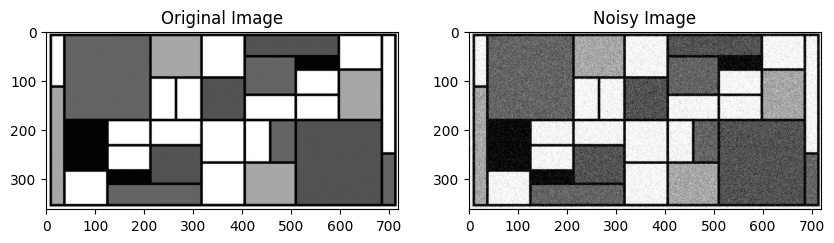

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(X, cmap="gray")
axs[0].set_title("Original Image")
axs[1].imshow(X_noisy, cmap="gray")
axs[1].set_title("Noisy Image")

Compute and visualize the threshold for denoising with:
- optimal hard threshold 
$$(4 / \sqrt{3})\sqrt{n} \gamma$$
- optimal hard threshold with unknown noise (slide 7, NAML_Lect300925_v2)
$$\tau = \omega(\beta) \sigma_{median}$$
$$\omega(\beta) \sim 0.56 \beta^3 - 0.95 \beta^2 + 1.82 \beta + 1.43, \quad \beta = m / n$$
- 90% energy (0.9 of cumulative sum)

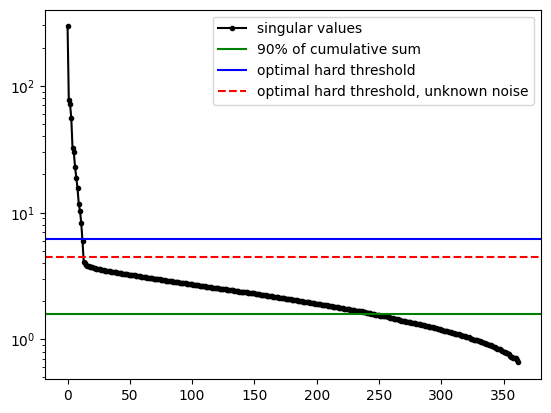

In [4]:
U, s, VT = np.linalg.svd(X_noisy, full_matrices=0)

# SOLUTION-BEGIN
# Truncate using optimal hard threshold
# the aspect ratio is not too distorted, we use the formula for the square
m, n = X.shape
cutoff = (4 / np.sqrt(3)) * np.sqrt(n) * gamma

# Truncate to keep 90% of cumulative sum
cumsum_thrshold = 0.90
cdS = np.cumsum(s) / np.sum(s)
r90 = np.min(np.where(cdS > cumsum_thrshold))
cutoff90 = s[r90]

# Supposing unknown noise
sigma_med = np.median(s)
beta = m / n
omega = 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43
cutoff_unknown = omega * sigma_med

plt.semilogy(s, "k.-", label="singular values")
plt.axhline(s[r90], color="g", label="90% of cumulative sum")
plt.axhline(cutoff, color="b", label="optimal hard threshold")
plt.axhline(
    cutoff_unknown,
    color="r",
    linestyle="--",
    label="optimal hard threshold, unknown noise",
)

plt.legend()
# SOLUTION-END

Compute the de-noised images with the previous thresholds

In [5]:
# SOLUTION-BEGIN
def denoise(U, s, VT, threshold):
  r = np.max(np.where(s > threshold))
  return U[:, : (r + 1)] @ np.diag(s[: (r + 1)]) @ VT[: (r + 1), :]

Xclean = denoise(U, s, VT, cutoff)
X90 = denoise(U, s, VT, cutoff90)
# SOLUTION-END

Plot and compare the denoised images. Plot also the error with respect to the original image.

Text(0.5, 1.0, 'Error: (4.26e+01)')

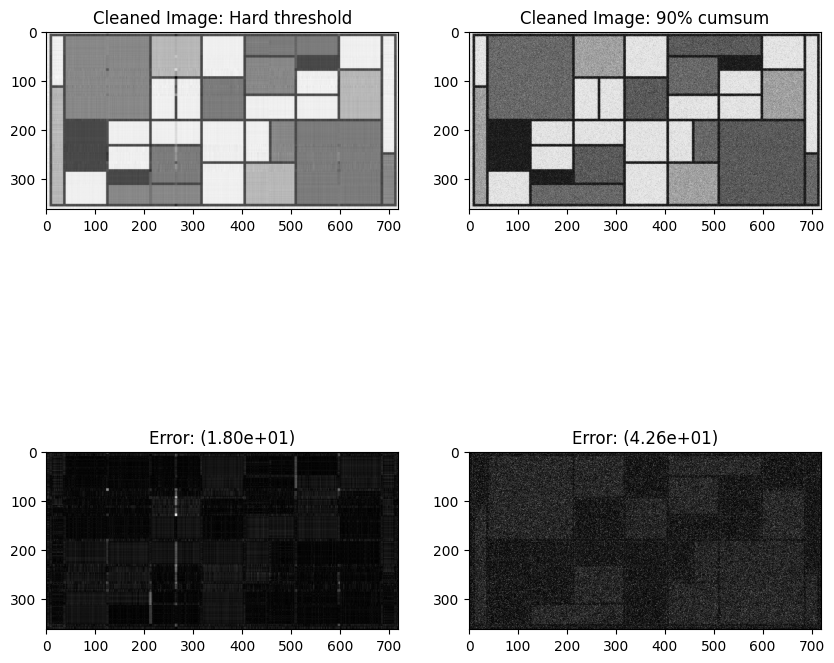

In [6]:
# SOLUTION-BEGIN
err_clean = np.abs(X - Xclean)
err_90 = np.abs(X - X90)
err_norm_clean = np.linalg.norm(err_clean, ord="fro")
err_norm_90 = np.linalg.norm(err_90, ord="fro")

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(Xclean, cmap="gray")
axs[0, 0].set_title("Cleaned Image: Hard threshold")
axs[0, 1].imshow(X90, cmap="gray")
axs[0, 1].set_title("Cleaned Image: 90% cumsum")

max_err = max([err_clean.max(), err_90.max()])
axs[1, 0].imshow(err_clean, cmap="gray", vmin=0, vmax=max_err)
axs[1, 0].set_title(f"Error: ({err_norm_clean:.2e})")
axs[1, 1].imshow(err_90, cmap="gray", vmin=0, vmax=max_err)
axs[1, 1].set_title(f"Error: ({err_norm_90:.2e})")
# SOLUTION-END

# Image compression through Singular Value Decomposition


Load a picture as a 3-dimensional `np.array`

In [1]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import rotate

# write here the import path of the image
# test this with
# - TarantulaNebula
# - mondrian
# - mondrian (rotated)
image_path = "./TarantulaNebula.jpg"

A = imread(image_path)
# A = rotate(A, 20, reshape=False)

Visualize the picture


(-0.5, 629.5, 566.5, -0.5)

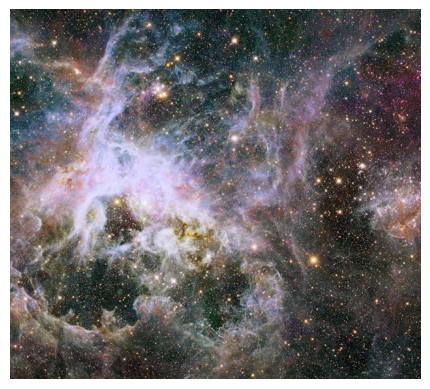

In [2]:
img = plt.imshow(A)
plt.axis("off")

Convert the picture to gray-scale and visualize it.


In [3]:
X = np.mean(A, axis=2)

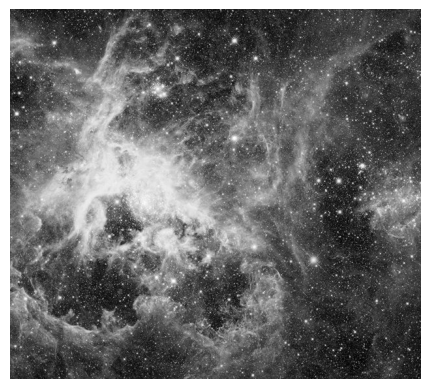

In [4]:
img = plt.imshow(X)
plt.axis("off")
img.set_cmap("gray")
plt.show()

What is the picture size?


In [5]:
X.shape

(567, 630)

Perform the SVD decomposition


In [6]:
# SOLUTION-BEGIN
U, s, VT = np.linalg.svd(X, full_matrices=False)

U.shape, s.shape, VT.shape
# SOLUTION-END

((567, 567), (567,), (567, 630))

Plot the trend of

- the singular values $\sigma_k$
- the cumulate fraction of singular values: $\frac{\sum_{i=1}^{k} \sigma_i}{\sum_{i=1}^{q} \sigma_i}$
- the fraction of the "explained variance": $\frac{\sum_{i=1}^{k} \sigma_i^2}{\sum_{i=1}^{q} \sigma_i^2}$


Text(0.5, 1.0, 'Explained variance')

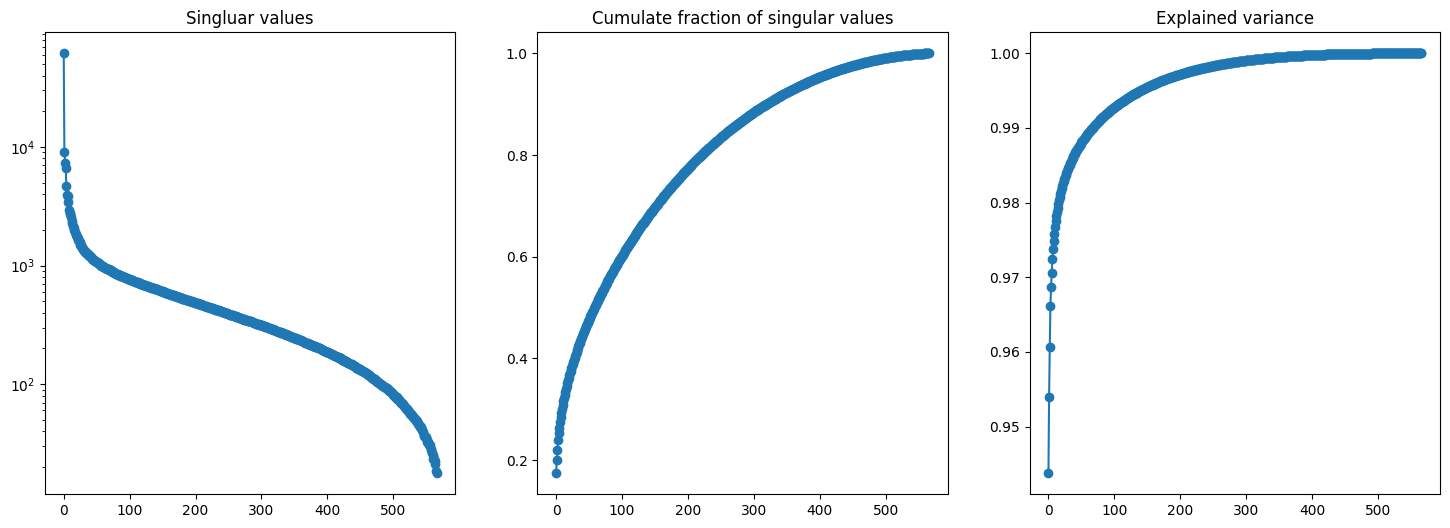

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
axes[0].semilogy(s, "o-")
axes[0].set_title("Singluar values")

axes[1].plot(np.cumsum(s) / np.sum(s), "o-")
axes[1].set_title("Cumulate fraction of singular values")

axes[2].plot(np.sqrt(np.cumsum(s**2) / np.sum(s**2)), "o-")
axes[2].set_title("Explained variance")

Visualize the best rank-$k$ matrices ($A_k$), for $k$ = 1, 5, 10, 50, 100, 500


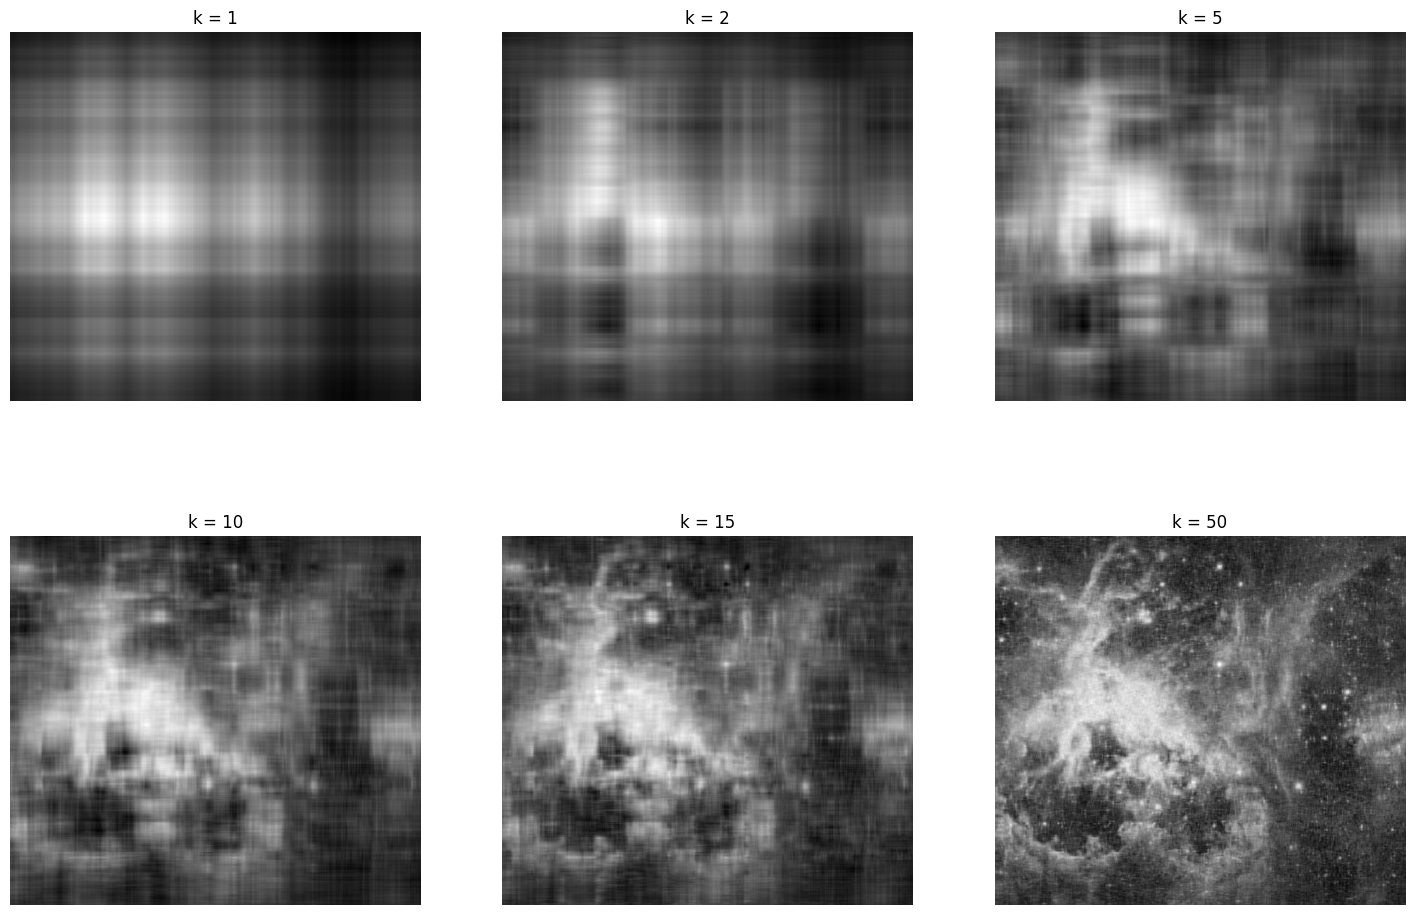

In [8]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axs = axs.reshape((-1,))
idxs = [1, 2, 5, 10, 15, 50]
for i in range(len(idxs)):
    k = idxs[i]
    # SOLUTION-BEGIN
    A_k = np.matmul(U[:, :k], np.matmul(np.diag(s[:k]), VT[:k, :]))
    axs[i].imshow(A_k, cmap="gray")
    # SOLUTION-END
    axs[i].set_title(f"k = {k}")
    axs[i].axis("off")

Visualize the $k$-th rank-1 matix, for $k$ = 1,2,...,6. 

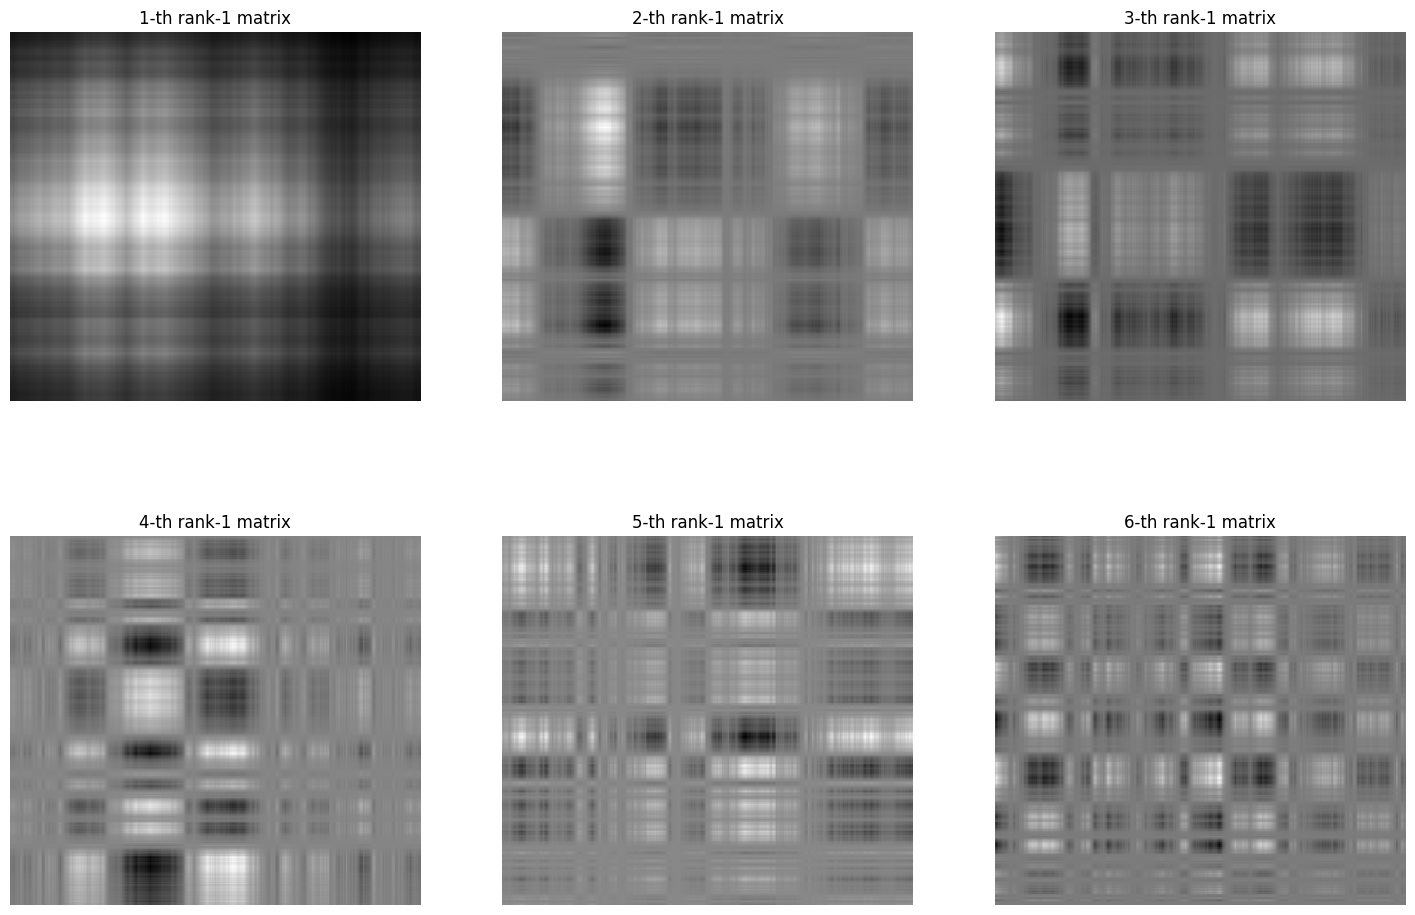

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axs = axs.reshape((-1,))
idxs = [1, 2, 3, 4, 5, 6]
for i, k in enumerate(idxs):
    # SOLUTION-BEGIN
    ukvk = np.outer(U[:, k - 1], VT[k - 1, :])
    axs[i].imshow(ukvk, cmap="gray")
    # SOLUTION-END
    axs[i].set_title(f"{k}-th rank-1 matrix")
    axs[i].axis("off")

## Randomized SVD

Implement now a function that computes the randomized SVD of rank $k$ of a generic matrix $A$.


In [10]:
def randomized_SVD(A, k):
    # SOLUTION-BEGIN
    _, n = A.shape
    P = np.random.randn(n, k)
    Z = A @ P
    Q, _ = np.linalg.qr(Z)
    Y = Q.T @ A
    Uy, sy, VTy = np.linalg.svd(Y, full_matrices=False)
    U = Q @ Uy
    # SOLUTION-END
    return U, sy, VTy

Set $k=100$ and compute the randomized SVD of the picture used above.

In [11]:
k = 100
# SOLUTION-BEGIN
U_rand, s_rand, VT_rand = randomized_SVD(X, k)
# SOLUTION-END

Plot the approximate singular values, their cumulate values and their cumulate squares, with a comparison of the ones obtained with the "exact" (i.e. non randomized) SVD.

Text(0.5, 1.0, 'explained variance')

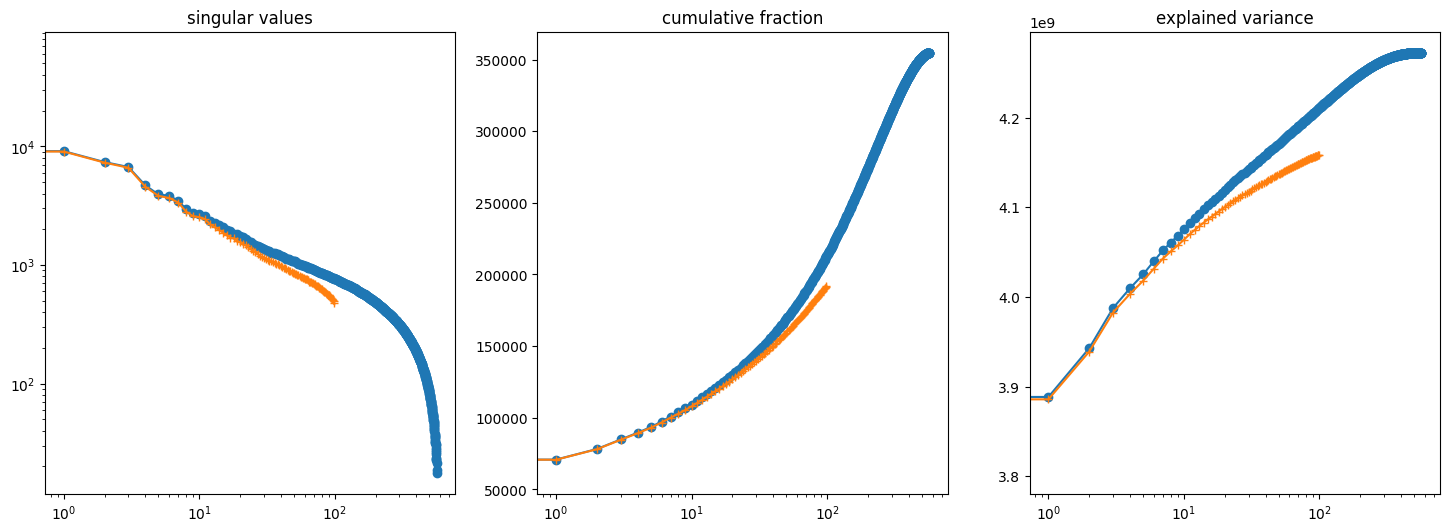

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# SOLUTION-BEGIN
axs[0].loglog(s, "o-")
axs[0].loglog(s_rand, "+-")
axs[0].set_title("singular values")

axs[1].semilogx(np.cumsum(s), "o-")
axs[1].semilogx(np.cumsum(s_rand), "+-")
axs[1].set_title("cumulative fraction")

axs[2].semilogx(np.cumsum(s**2), "o-")
axs[2].semilogx(np.cumsum(s_rand**2), "+-")
axs[2].set_title("explained variance")
# SOLUTION-END

Compare the original picture with the best rank-$k$ matrix obtained through SVD and the best rank-$k$ matrix obtained through randomized SVD.

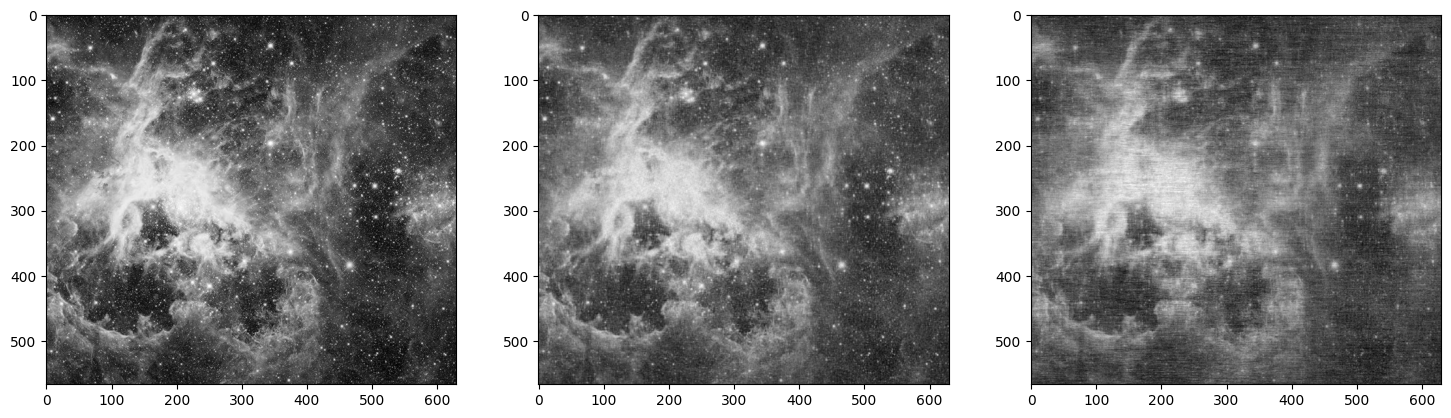

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# SOLUTION-BEGIN
axs[0].imshow(X, cmap="gray")
axs[1].imshow(U[:, :k] @ np.diag(s[:k]) @ VT[:k, :], cmap="gray")
axs[2].imshow(U_rand @ np.diag(s_rand) @ VT_rand, cmap="gray")
# SOLUTION-END

# SVD decomposition with `scipy`

Import the required modules

In [1]:
import scipy.linalg as la
import numpy as np

Generate a random 5x4 matrix

In [2]:
np.random.seed(0)

A = np.random.rand(5,4)
A

array([[0.5488135 , 0.71518937, 0.60276338, 0.54488318],
       [0.4236548 , 0.64589411, 0.43758721, 0.891773  ],
       [0.96366276, 0.38344152, 0.79172504, 0.52889492],
       [0.56804456, 0.92559664, 0.07103606, 0.0871293 ],
       [0.0202184 , 0.83261985, 0.77815675, 0.87001215]])

## `<numpy|scipy>.linalg.svd` 

Equivalent implementations:
- https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html



### Full SVD (`full_matrices = True` - default)

**input:**

$A \in \mathbb{R}^{m\times n}$

**output:**

$U \in \mathbb{R}^{m\times m}, S \in \mathbb{R}^{m\times n}, V \in \mathbb{R}^{n\times n}$

or, more precisely

$\boldsymbol{\sigma} \in \mathbb{R}^{q} $

where $q = \min(m,n)$.


In [3]:
U, s, VT = np.linalg.svd(A)
#U, s, VT = la.svd(A)
print('U shape: ', U.shape)
print('s shape: ', s.shape)
print('VT shape: ', VT.shape)

U shape:  (5, 5)
s shape:  (4,)
VT shape:  (4, 4)


Build the matrix $S$

In [4]:
S = np.zeros(A.shape)
for i in range(len(s)):
    S[i, i] = s[i]
S

array([[2.64618677, 0.        , 0.        , 0.        ],
       [0.        , 0.83351254, 0.        , 0.        ],
       [0.        , 0.        , 0.70753001, 0.        ],
       [0.        , 0.        , 0.        , 0.29842614],
       [0.        , 0.        , 0.        , 0.        ]])

In [5]:
S = la.diagsvd(s, A.shape[0], A.shape[1])
S

array([[2.64618677, 0.        , 0.        , 0.        ],
       [0.        , 0.83351254, 0.        , 0.        ],
       [0.        , 0.        , 0.70753001, 0.        ],
       [0.        , 0.        , 0.        , 0.29842614],
       [0.        , 0.        , 0.        , 0.        ]])

Reconstruct the matrix $A$

In [6]:
A_svd = np.matmul(U, np.matmul(S,VT))
# equivalently: A_svd = U @ S @ VT
print(f"err: {(la.norm(A - A_svd) / la.norm(A))}")

err: 4.624308861561109e-16


### Thin SVD (`full_matrices = False`)

**input:**

$A \in \mathbb{R}^{m\times n}$

**output:**

$U \in \mathbb{R}^{m\times q}, S \in \mathbb{R}^{q\times q}, V \in \mathbb{R}^{n\times q}$

or, more precisely

$\boldsymbol{\sigma} \in \mathbb{R}^{q} $

where $q = \min(m,n)$.



In [7]:
U, s, VT = la.svd(A, full_matrices=False)
print('U shape: ', U.shape)
print('s shape: ', s.shape)
print('VT shape: ', VT.shape)

U shape:  (5, 4)
s shape:  (4,)
VT shape:  (4, 4)


Build the matrix $S$

In [8]:
S = np.diag(s)
S

array([[2.64618677, 0.        , 0.        , 0.        ],
       [0.        , 0.83351254, 0.        , 0.        ],
       [0.        , 0.        , 0.70753001, 0.        ],
       [0.        , 0.        , 0.        , 0.29842614]])

Reconstruct the matrix $A$

In [9]:
A_svd = np.matmul(U, np.matmul(S,VT))
print(f"err: {la.norm(A - A_svd) / la.norm(A)}")

err: 4.624308861561109e-16


### A note on vectorization
Vectorization refers to the practice of replacing explicit loops with high-level mathematical operations that act on entire arrays or matrices at once. This leads to much better performance because it replaces slow Python loops with fast, optimized C and Fortran operations.

Indeed, we could be inclined to reconstruct $A_k$ with a for loop and the explicit formula
$$A_k = \sigma_1 u_1 v_1^T + ... + \sigma_k u_k v_k^T.$$

Let's measure the time taken for this operation for a matrix $A$ that is a bit larger

In [10]:
import time

A = np.random.rand(1000, 1500)
U, s, VT = la.svd(A, full_matrices=False)
S = np.diag(s)


Time the reconstruction with a for loop

In [11]:
start_time = time.time()

A_reconstructed_loop = np.zeros_like(A)
for i in range(len(s)):
    A_reconstructed_loop += s[i] * np.outer(U[:, i], VT[i, :])

loop_time = time.time() - start_time

Time the vectorized reconstruction using matrix multiplication

In [12]:
start_time = time.time()

A_reconstructed_matmult = U @ S @ VT

matmult_time = time.time() - start_time

If $S \in \mathbb R^{q \times q}$ diagonal (with elements on the diagonal equal to $s \in \mathbb R^{q}$), then the each of $US$ is equal to the element wise product of that row of $U$ with $s$, namely, $(US)_{i,j} = U_{i, j} s_j$. Indeed, $(US)_{i,j} = \sum_{k} U_{i, k} S_{k, j} = U_{i, j} S_{j, j} = U_{i, j} s_j$, since $S_{k, j} = 0$ iff $k \neq j$.

In [13]:
start_time = time.time()

# here we are using broadcasting to avoid the creation of a diagonal matrix
# see: https://numpy.org/doc/stable/user/basics.broadcasting.html
A_reconstructed_vectorized = (U * s) @ VT

vectorized_time = time.time() - start_time

We compare the results

In [14]:
print(f"Time for reconstruction using for loop: {loop_time:.6f} seconds")
print(f"Time for vectorized reconstruction: {vectorized_time:.6f} seconds")
print(f"Matmult is {loop_time / matmult_time:.1f} times faster than the loop")
print(f"Vectorized is {matmult_time / vectorized_time:.1f} times faster than the matmult")

difference = np.abs(A_reconstructed_loop - A_reconstructed_vectorized).max()
print(f"Difference between the two reconstructions: {difference:.6e}")

Time for reconstruction using for loop: 2.981118 seconds
Time for vectorized reconstruction: 0.033559 seconds
Matmult is 81.4 times faster than the loop
Vectorized is 1.1 times faster than the matmult
Difference between the two reconstructions: 5.329071e-15


# Background Removal

We aim to remove the background from a video and be able to select only the moving parts using SVD.

We use as benchmark the real video 003 dataset from BMC 2012 [Background Models Challenge Dataset](http://backgroundmodelschallenge.eu/)


In [3]:
!wget http://backgroundmodelschallenge.eu/data/real/Video_003.zip
!unzip Video_003.zip

--2025-10-03 15:57:22--  http://backgroundmodelschallenge.eu/data/real/Video_003.zip
Resolving backgroundmodelschallenge.eu (backgroundmodelschallenge.eu)... 145.239.37.162, 2001:41d0:301::30
Connecting to backgroundmodelschallenge.eu (backgroundmodelschallenge.eu)|145.239.37.162|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3279920 (3.1M) [application/zip]
Saving to: ‘Video_003.zip.1’

Video_003.zip.1     100%[===================>]   3.13M  6.00MB/s    in 0.5s    

2025-10-03 15:57:23 (6.00 MB/s) - ‘Video_003.zip.1’ saved [3279920/3279920]

Archive:  Video_003.zip
   creating: Video_003/
   creating: Video_003/img/
  inflating: Video_003/img/Img_00250.bmp  
  inflating: Video_003/img/Img_00251.bmp  
  inflating: Video_003/img/Img_00252.bmp  
  inflating: Video_003/img/Img_00350.bmp  
  inflating: Video_003/img/Img_00351.bmp  
  inflating: Video_003/img/Img_00352.bmp  
  inflating: Video_003/img/Img_00450.bmp  
  inflating: Video_003/img/Img_00451.bmp  
  inf

Import needed libraries:


In [4]:
import moviepy.editor as mpe
import numpy as np
import skimage.transform

%matplotlib inline
import matplotlib.pyplot as plt

Load the video and check its duration


In [5]:
video = mpe.VideoFileClip("Video_003/Video_003.avi")
video.duration

113.57

Let us visualize the video, and actually check its contents


In [6]:
video.subclip(0, 5).ipython_display(width=300)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### Helper Methods

In order to work with the video, we need to implement a couple of helper methods:

- a method to tranform a color image into a gray image (SVD works with 2D matrices, thus, for sake of simplicity, we avoid repeating the same operations to each channel of the image by using a gray-scale image)
- a method to transform the video into a numpy matrix, we also downscale the video to reduce the computational cost of applying the SVD. We can unroll a frame into a single tall column. So instead of having a 2D picture, we have a column. This isn't very human-readable, but it's handy because it lets us stack the images from different times on top of one another, to put a video all into 1 matrix.


In [7]:
def create_data_matrix_from_video(clip, dims):
    number_of_frames = int(clip.fps * clip.duration)
    flatten_gray_frames = []
    for i in range(number_of_frames):
        # get_frame takes as input the time of the frame
        frame = clip.get_frame(i / clip.fps)
        # to gray scale
        gray_frame = np.mean(frame[..., :3], axis=-1).astype(int)
        # resize to reduce computational cost
        small_gray_frame = skimage.transform.resize(gray_frame, dims)
        # each frame becomes a column vector of A
        flatten_gray_frames.append(small_gray_frame.flatten())
    return np.vstack(flatten_gray_frames).T

We set some parameters and create the matrix


In [8]:
scale = 0.50  # Adjust scale to change resolution of image
width, height = video.size
dims = (int(height * scale), int(width * scale))
A = create_data_matrix_from_video(video, dims)
print("frame size:", dims)
print("video matrix size:", A.shape)

frame size: (120, 160)
video matrix size: (19200, 794)


Let's visualize the 140-th frame of the video (rescaled and decolored)


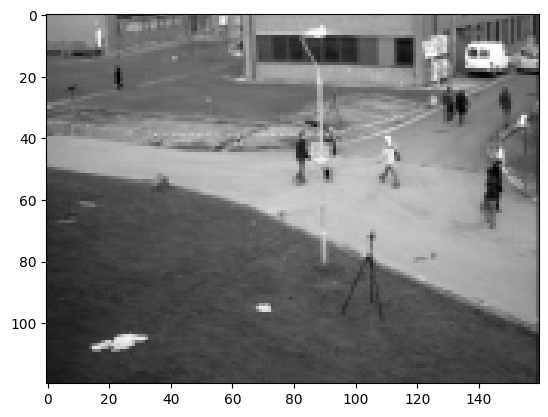

In [9]:
plt.imshow(np.reshape(A[:, 140], dims), cmap="gray")

What does the matrix A look like instead?


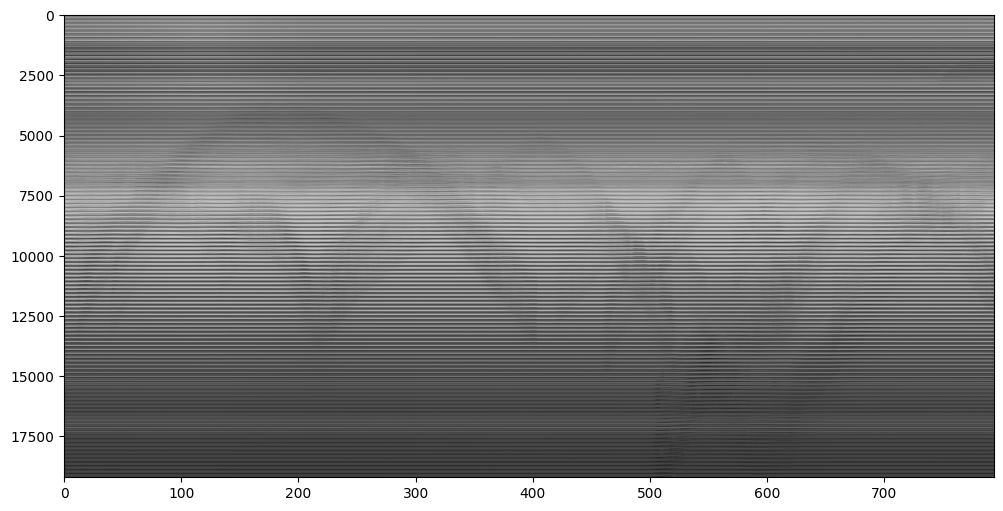

In [10]:
plt.figure(figsize=(12, 6))
plt.imshow(A, cmap="gray", aspect="auto")

**Questions**: What are those wavy black lines? What are the horizontal lines?


## Apply the SVD

We apply the SVD to our matrix $A$


In [11]:
import time


def my_svd(XX, k):
    # HOMEWORK: replace here the svd with rSVD and comment the results
    return np.linalg.svd(XX, full_matrices=False)


t0 = time.time()
U, s, VT = my_svd(A, 10)
print(f"SVD elapsed {time.time() - t0: .2f} [s]")


U.shape, s.shape, VT.shape

SVD elapsed  1.73 [s]


((19200, 794), (794,), (794, 794))

Check that they are a decomposition of A


In [12]:
reconstructed_A = U @ np.diag(s) @ VT
np.allclose(A, reconstructed_A)

True

Since the background is more or less constant during the video (the horizontal lines of A), we suppose that the background can be reconstructed using few singular values


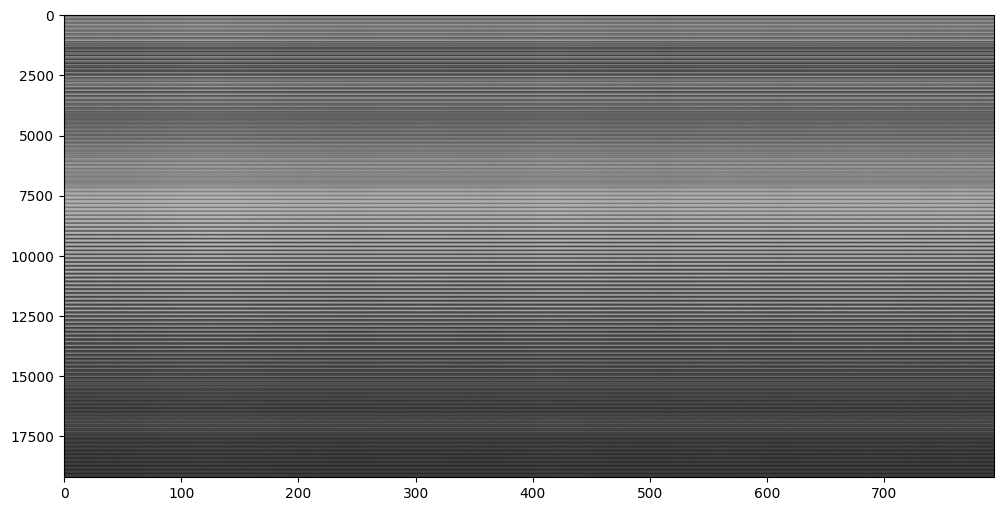

In [13]:
n_singular_values = 1
background = U[:, 0:n_singular_values] * s[0] * VT[0:n_singular_values, :]
plt.figure(figsize=(12, 6))
plt.imshow(background, cmap="gray", aspect="auto")

The SVD has done all the heavy liflting!
Now we "just" have to visualize the results in a human comprehensible way.

Let's visualize the original video, the background and the foreground at some fixed instances in time.


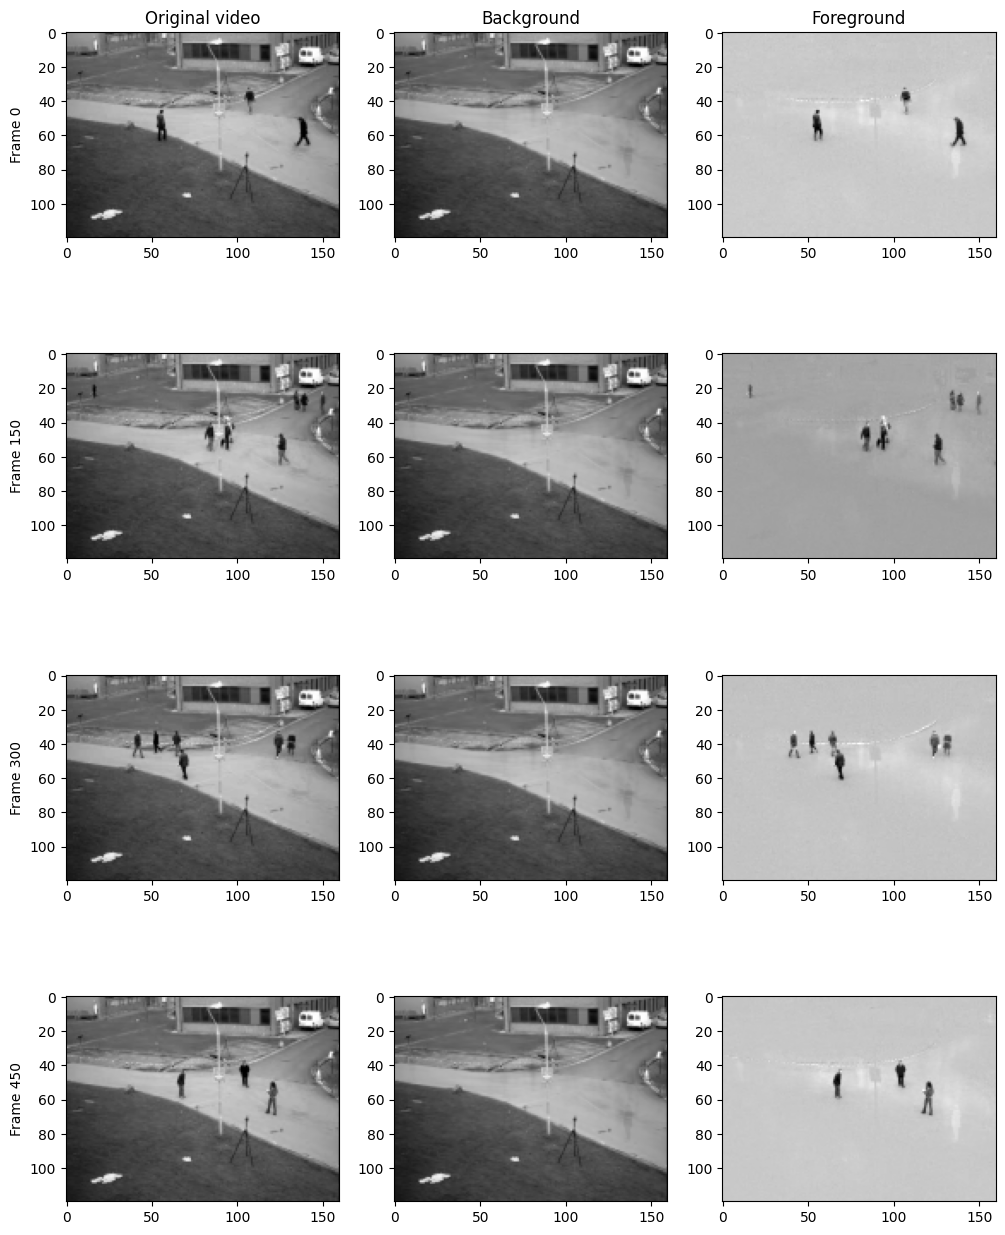

In [14]:
def plot_frames(A, background, time_ids):
    fig, axs = plt.subplots(len(time_ids), 3, figsize=(12, 4 * len(time_ids)))
    for i, t_id in enumerate(time_ids):
        axs[i, 0].imshow(np.reshape(A[:, t_id], dims), cmap="gray")
        axs[i, 1].imshow(np.reshape(background[:, t_id], dims), cmap="gray")
        axs[i, 2].imshow(
            np.reshape(A[:, t_id] - background[:, t_id], dims), cmap="gray"
        )

        axs[i, 0].set_ylabel(f"Frame {t_id}")

        if i == 0:
            axs[0, 0].set_title("Original video")
            axs[0, 1].set_title("Background")
            axs[0, 2].set_title("Foreground")


time_ids = [0, 150, 300, 450]
plot_frames(A, background, time_ids)

What are the downsides?

SVD was really slow (remember that we also compressed our frames to reduce the computational cost). Moreover, we threw away a lot of our calculation, we used just one singular value.


### Homework
Try to use the rSVD instead of the SVD.
Compute the time savings and compare qualitatively the results.

# 1st order Training (optimization) methods


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import jax.numpy as jnp
import jax

Let us consider the following function

$$
f(x) = e^{-\frac{x}{10}}\sin(x) + \frac{1}{10} \cos(\pi x)
$$

defined over the interval $[0, 10]$.


In [ ]:
f = lambda x: np.sin(x) * np.exp(-0.1 * x) + 0.1 * np.cos(np.pi * x)
a, b = 0, 10

Define a function `get_training_data` that returns a collection of `N` training samples, adding a noise sampled from a normal distribution with zero mean and standard deviation `noise`. The output should be a pair of `numpy` matrices `x, y`, of dimension `N` times 1.


In [ ]:
def get_training_data(N, noise):
    np.random.seed(0)  # for reproducibility
    x = np.linspace(a, b, N)[:, None]
    y = f(x) + noise * np.random.randn(N, 1)
    return x, y

Plot now the function $f(x)$ in the considered interval, together with 100 training samples with noise magnitude equal to 0.05.


In [ ]:
x_fine = np.linspace(a, b, 1000)[:, None]
plt.plot(x_fine, f(x_fine))

xx, yy = get_training_data(100, 0.05)
plt.plot(xx, yy, "o")

Write a function `initialize_params` that, given the input `layers_size = [n1, n2, ..., nL]`, generates the parameters associated with an ANN, having as many layers as the number of elements of `layers_size`, with as many neurons as `n1`, `n2`, etc.

Inizialize weights sampling from a standard Gaussian distribution and biases with zero values.


In [ ]:
def initialize_params(layers_size):
    np.random.seed(0)  # for reproducibility
    params = list()
    for i in range(len(layers_size) - 1):
        W = np.random.randn(layers_size[i + 1], layers_size[i])
        b = np.zeros((layers_size[i + 1], 1))
        params.append(W)
        params.append(b)
    return params

Write a function `ANN` that implements an ANN, given the parameters `params`. Use $\tanh$ as activation function and do not apply the activation function to the last layer.

By convention, both the input and the output have:

- 1 sample per row
- 1 feature per column


In [ ]:
def ANN(x, params):
    # layer = x.T
    layer = (2 * x.T - (a + b)) / (b - a)
    num_layers = int(len(params) / 2 + 1)
    weights = params[0::2]
    biases = params[1::2]
    for i in range(num_layers - 1):
        layer = jnp.dot(weights[i], layer) - biases[i]
        if i < num_layers - 2:
            layer = jnp.tanh(layer)
    return layer.T

Implement a function `loss`, that, given the input `x`, the target output `y` (i.e. the "labels") and the parameters `params`, returns the quadratic loss, defined as:

$$
\mathcal{L}(\mathbf{x}, \mathbf{y}, \boldsymbol{\theta}) = \frac{1}{m} \sum_{i=1}^m (y_i - \mathrm{ANN}(x_i, \boldsymbol{\theta}))^2
$$

where $m$ is the number of samples in `x`, `y` and $\boldsymbol{\theta}$ are the ANN parameters.


In [ ]:
def loss(x, y, params):
    error = ANN(x, params) - y
    return jnp.mean(error * error)

Test your code, by generating the parameters associated with an ANN with two hidden layers with 5 neurons each and by computing the associated loss.


In [ ]:
params = initialize_params([1, 5, 5, 1])
loss(xx, yy, params)

The following cell provides an helper class that allows pnline plots during the training loop. Just run the cell, we will use it later.


In [ ]:
from IPython import display


class Callback:
    def __init__(self, refresh_rate=250):
        self.refresh_rate = refresh_rate
        self.fig, self.axs = plt.subplots(1, 2, figsize=(16, 8))
        self.x_fine = np.linspace(a, b, 200)[:, None]
        self.epoch = 0
        self.__call__(-1)

    def __call__(self, epoch):
        self.epoch = epoch
        if (epoch + 1) % self.refresh_rate == 0:
            self.draw()
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(1e-16)

    def draw(self):
        if self.epoch > 0:
            self.axs[0].clear()
            self.axs[0].loglog(history)
            self.axs[0].set_title("epoch %d" % (self.epoch + 1))

        self.axs[1].clear()
        self.axs[1].plot(self.x_fine, f(self.x_fine))
        self.axs[1].plot(self.x_fine, ANN(self.x_fine, params))
        self.axs[1].plot(xx, yy, "o")

## Gradient Descent

Implement the GD method:

$$
\begin{split}
& \boldsymbol{\theta}^{(0)} \text{given} \\
& \text{for } k = 0, 1, \dots , n_{\text{epochs}} - 1\\
& \qquad \mathbf{g}^{(k)} = \frac{1}{N} \sum_{i=1}^N \nabla_{\boldsymbol{\theta}} \mathcal{L}(x_i, y_i, \boldsymbol{\theta}^{(k)}) \\
& \qquad \boldsymbol{\theta}^{(k+1)} = \boldsymbol{\theta}^{(k)} - \lambda \mathbf{g}^{(k)}
\end{split}
$$

where N is the number of training samples. At each iteration, append the current cost to the list `history`.

Hints:

- Use `jax.jit` to speedup the evaluation of the loss and of the gradients.
- To us the visualization callback, just initialize it outside the training loop with:

```python
cb = Callback(refresh_rate = 250)
```

and after each training epoch call `cb(epoch)`, where `epoch` is the epoch index. Finally, call `cb.draw()` when training is over.

Test you code with:

- 100 training points
- noise magnitude 0.05
- two hidden layers of 5 neurons each
- 2000 epochs

Experiment different choices of learning rate $\lambda$, trying to maximize the performance of the algorithm.

Does it look like your ANN is struggling to learn? Try to figure out why and figure out how to fix this issue.


In [ ]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 2000
learning_rate = 1e-1
########################################

xx, yy = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums=2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate=200)

for epoch in range(num_epochs):
    # SOLUTION-BEGIN
    grads = grad_jit(xx, yy, params)
    for i in range(len(params)):
        params[i] -= learning_rate * grads[i]
    # SOLUTION-END
    history.append(loss_jit(xx, yy, params))
    cb(epoch)
cb.draw()

print("loss: %1.3e" % history[-1])

## Stochastic Gradient Descent

Implement the SGD method:

$$
\begin{split}
& \boldsymbol{\theta}^{(0)} \text{given} \\
& \text{for } k = 0, 1, \dots , n_{\text{epochs}} - 1\\
& \qquad \mathbf{g}^{(k)} = \frac{1}{|I_k|} \sum_{i \in I_k} \nabla_{\boldsymbol{\theta}} \mathcal{L}(x_i, y_i, \boldsymbol{\theta}^{(k)}) \\
& \qquad \boldsymbol{\theta}^{(k+1)} = \boldsymbol{\theta}^{(k)} - \lambda_k \mathbf{g}^{(k)}
\end{split}
$$

where $I_k$ is the current minibatch. To select it, use the function [np.random.choice](https://docs.scipy.org/doc//numpy-1.10.4/reference/generated/numpy.random.choice.html) with replacement.

Consider a linear decay of the learning rate:

$$
\lambda_k = \max\left(\lambda_{\textnormal{min}}, \lambda_{\textnormal{max}} \left(1 - \frac{k}{K}\right)\right)
$$

Test different choices of batch size and try to optimize the learning rate decay strategy.


In [ ]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 20000
learning_rate_max = 1e-1
learning_rate_min = 2e-2
learning_rate_decay = 10000
batch_size = 10
########################################

xx, yy = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums=2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate=250)

for epoch in range(num_epochs):
    # SOLUTION-BEGIN
    learning_rate = max(
        learning_rate_min, learning_rate_max * (1 - epoch / learning_rate_decay)
    )
    idxs = np.random.choice(n_training_points, batch_size)
    grads = grad_jit(xx[idxs, :], yy[idxs, :], params)
    for i in range(len(params)):
        params[i] -= learning_rate * grads[i]
    # SOLUTION-END

    history.append(loss_jit(xx, yy, params))
    cb(epoch)
cb.draw()

print("loss: %1.3e" % history[-1])

## Stochastic Gradient Descent with momentum

Implement the SGD method with momentum:

$$
\begin{split}
& \boldsymbol{\theta}^{(0)} \text{given}, \mathbf{v}^{(0)}=\mathbf{0}  \\
& \text{for } k = 0, 1, \dots , n_{\text{epochs}} - 1\\
& \qquad \mathbf{g}^{(k)} = \frac{1}{|I_k|} \sum_{i \in I_k} \nabla_{\boldsymbol{\theta}} \mathcal{L}(x_i, y_i, \boldsymbol{\theta}^{(k)}) \\
& \qquad \mathbf{v}^{(k+1)} = \alpha \mathbf{v}^{(k)} -  \lambda_k \mathbf{g}^{(k)}\\
& \qquad \boldsymbol{\theta}^{(k+1)} = \boldsymbol{\theta}^{(k)} + \mathbf{v}^{(k+1)}
\end{split}
$$

Test different choices of $\alpha$.


In [ ]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 20000
learning_rate_max = 1e-1
learning_rate_min = 1e-2
learning_rate_decay = 10000
batch_size = 10
alpha = 0.9
########################################

xx, yy = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums=2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate=250)

velocity = [0.0 for _ in range(len(params))]
for epoch in range(num_epochs):
    # SOLUTION-BEGIN
    learning_rate = max(
        learning_rate_min, learning_rate_max * (1 - epoch / learning_rate_decay)
    )
    idxs = np.random.choice(n_training_points, batch_size)
    grads = grad_jit(xx[idxs, :], yy[idxs, :], params)

    for i in range(len(params)):
        velocity[i] = alpha * velocity[i] - learning_rate * grads[i]
        params[i] += velocity[i]
    # SOLUTION-END

    history.append(loss_jit(xx, yy, params))
    cb(epoch)
cb.draw()

print("loss: %1.3e" % history[-1])

## AdaGrad

Implement the AdaGrad algorithm:

$$
\begin{split}
& \boldsymbol{\theta}^{(0)} \text{given}, \mathbf{r}^{(0)}=\mathbf{0}  \\
& \text{for } k = 0, 1, \dots , n_{\text{epochs}} - 1\\
& \qquad \mathbf{g}^{(k)} = \frac{1}{|I_k|} \sum_{i \in I_k} \nabla_{\boldsymbol{\theta}} \mathcal{L}(x_i, y_i, \boldsymbol{\theta}^{(k)}) \\
& \qquad \mathbf{r}^{(k+1)} = \mathbf{r}^{(k)} + \mathbf{g}^{(k)} \odot \mathbf{g}^{(k)}\\
& \qquad \boldsymbol{\theta}^{(k+1)} = \boldsymbol{\theta}^{(k)} -
\frac{\lambda}{\delta + \sqrt{\mathbf{r}^{(k+1)}}} \odot \mathbf{g}^{(k)}
\end{split}
$$

where $\delta = 10^{-7}$ is a small constant.
Notice that the operations in the last line should be intepreted "componentwise".
test different choices of the learning rate $\lambda$.


In [ ]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 20000
batch_size = 10
learning_rate = 1e-1
delta = 1e-7
########################################

xx, yy = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums=2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate=250)

cumulated_square_grad = [0.0 for i in range(len(params))]
for epoch in range(num_epochs):
    # SOLUTION-BEGIN
    idxs = np.random.choice(n_training_points, batch_size)
    grads = grad_jit(xx[idxs, :], yy[idxs, :], params)

    for i in range(len(params)):
        cumulated_square_grad[i] += grads[i] * grads[i]
        params[i] -= (
            learning_rate / (delta + jnp.sqrt(cumulated_square_grad[i])) * grads[i]
        )
    # SOLUTION-END

    history.append(loss_jit(xx, yy, params))
    cb(epoch)
cb.draw()

print("loss: %1.3e" % history[-1])

## RMSProp

Implement the RMSProp algorithm:

$$
\begin{split}
& \boldsymbol{\theta}^{(0)} \text{given}, \mathbf{r}^{(0)}=\mathbf{0}  \\
& \text{for } k = 0, 1, \dots , n_{\text{epochs}} - 1\\
& \qquad \mathbf{g}^{(k)} = \frac{1}{|I_k|} \sum_{i \in I_k} \nabla_{\boldsymbol{\theta}} \mathcal{L}(x_i, y_i, \boldsymbol{\theta}^{(k)}) \\
& \qquad \mathbf{r}^{(k+1)} = \rho \mathbf{r}^{(k)} + (1 - \rho)\mathbf{g}^{(k)} \odot \mathbf{g}^{(k)}\\
& \qquad \boldsymbol{\theta}^{(k+1)} = \boldsymbol{\theta}^{(k)} -
\frac{\lambda}{\delta + \sqrt{\mathbf{r}^{(k+1)}}} \odot \mathbf{g}^{(k)}
\end{split}
$$

where $\delta = 10^{-7}$ is a small constant.
test different choices of the learning rate $\lambda$ and decay rate $\rho$.


In [ ]:
# Data
n_training_points = 100
noise = 0.05
# Hyperparameters
layers_size = [1, 5, 5, 1]
# Training options
num_epochs = 20000
batch_size = 50
learning_rate = 1e-3
decay_rate = 0.9
delta = 1e-7
########################################

xx, yy = get_training_data(n_training_points, noise)
params = initialize_params(layers_size)

loss_jit = jax.jit(loss)
grad_jit = jax.jit(jax.grad(loss, argnums=2))

history = list()
history.append(loss_jit(xx, yy, params))

cb = Callback(refresh_rate=250)

cumulated_square_grad = [0.0 for i in range(len(params))]
for epoch in range(num_epochs):
    # SOLUTION-BEGIN
    idxs = np.random.choice(n_training_points, batch_size)
    grads = grad_jit(xx[idxs, :], yy[idxs, :], params)

    for i in range(len(params)):
        cumulated_square_grad[i] = (
            decay_rate * cumulated_square_grad[i]
            + (1 - decay_rate) * grads[i] * grads[i]
        )
        params[i] -= (
            learning_rate / (delta + jnp.sqrt(cumulated_square_grad[i])) * grads[i]
        )
    # SOLUTION-END
    
    history.append(loss_jit(xx, yy, params))
    cb(epoch)
cb.draw()

print("loss: %1.3e" % history[-1])

# California Housing data from 1990 US Census

In this lab we will rely on [Pandas](https://pandas.pydata.org/) and [Seaborn](http://seaborn.pydata.org/) to inspect and visualize data.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import jax.numpy as jnp
import jax

Load the dataset (if you are using Google Colab, it is already in the `sample_data` folder!).


In [ ]:
data = pd.read_csv("./california_housing_train.csv")

## Data inspection

Display some basic information.


In [ ]:
data.head()

In [ ]:
data.info()

In [ ]:
data.describe()

We are interested in predicting the field `median_house_value`. Plot its distribution.


In [ ]:
sns.histplot(data["median_house_value"], kde=True)

It looks like the distribution tail has been truncated. Get rid of it to ease the prediction.


In [ ]:
data = data[data["median_house_value"] < 500001]
sns.histplot(data["median_house_value"], kde=True)

Use a scatterplot to visualize the geograhical distribution of the houses.


In [ ]:
sns.scatterplot(data=data, x="longitude", y="latitude", hue="median_house_value")

Look for linear correlations among features.


In [ ]:
data.corr()

In [ ]:
sns.heatmap(data.corr(), annot=True, cmap="vlag_r", vmin=-1, vmax=1)

In [ ]:
sns.scatterplot(data=data, x="latitude", y="median_house_value")

## Data normalization

Apply an affine transformation to the data, so that each feature has zero mean and unitary standard deviation.


In [ ]:
data_mean = data.mean()
data_std = data.std()
data_normalized = (data - data_mean) / data_std

data_normalized.describe()

In [ ]:
_, ax = plt.subplots(figsize=(16, 6))
sns.violinplot(data=data_normalized, ax=ax)

## Train-validation split

Shuffle the data (**hint:** use the [np.random.shuffle](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html) function) and split the data as follows:

- put 80% in the train dataset
- put 20% in the validation dataset


In [ ]:
np.random.seed(0)  # for reproducibility
data_normalized_np = data_normalized.to_numpy()
np.random.shuffle(data_normalized_np)

fraction_validation = 0.2
num_train = int(data_normalized_np.shape[0] * (1 - fraction_validation))
x_train = data_normalized_np[:num_train, :-1]
y_train = data_normalized_np[:num_train, -1:]
x_valid = data_normalized_np[num_train:, :-1]
y_valid = data_normalized_np[num_train:, -1:]

## ANN setup

Write a function `initialize_params` that, given the input `layers_size = [n1, n2, ..., nL]`, generates the parameters associated with an ANN, having as many layers as the number of elements of `layers_size`, with as many neurons as `n1`, `n2`, etc.

To initialize the parameters, employ the following strategy:

- Inizialize the biases with zero value.
- Inizialize the weights sampling from a Gaussian distribution with zero mean and with standard deviation
  $$
  \sqrt{\frac{2}{n + m}}
  $$
  where $n$ and $m$ are the number of input and output neurons of the corresponding weights matrix (this is known as "Glorot Normal" or "Xavier Normal", see [Glorot, Bengio 2010](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)).

Other popular initializations strategies are:

- Gaussian distribution with zero mean and with standard deviation (for some constant $K$)
  $$
  \frac{K}{\sqrt{n}}
  $$
- Uniform distribution
  $$
  \left[-\sqrt{\frac{1}{n}}, \sqrt{\frac{1}{n}}\right]
  $$
- Uniform distribution (this is known as "Glorot Uniform" or "Xavier Uniform")
  $$
  \left[-\sqrt{\frac{6}{n + m}}, \sqrt{\frac{6}{n + m}}\right]
  $$


In [ ]:
# SOLUTION-BEGIN
def initialize_params(layers_size):
    np.random.seed(0)  # for reproducibility
    params = list()
    for i in range(len(layers_size) - 1):
        W = np.random.randn(layers_size[i + 1], layers_size[i]) * np.sqrt(
            2 / (layers_size[i + 1] + layers_size[i])
        )
        b = np.zeros((layers_size[i + 1], 1))
        params.append((W, b))
    return params


params = initialize_params([8, 5, 5, 1])
# SOLUTION-END

Implement a generic feedforward ANN with a function `y = ANN(x, params)', using $\tanh$ as activation function.

By convention, both the input and the output have:

- 1 sample per row
- 1 feature per column


In [ ]:
# SOLUTION-BEGIN
activation = jnp.tanh
activation = lambda x: jnp.maximum(0.0, x)


def ANN(x, params):
    layer = x.T
    for i, (W, b) in enumerate(params):
        layer = W @ layer - b
        if i < len(params) - 1:
            layer = activation(layer)
    return layer.T


ANN(x_train, params)
# SOLUTION-END

Implement the quadratic (MSE) loss function `L = loss(x, y, params)`, defined as:

$$
\mathcal{L}(\mathbf{x}, \mathbf{y}, \boldsymbol{\theta}) = \frac{1}{m} \sum_{i=1}^m (y_i - \mathrm{ANN}(x_i, \boldsymbol{\theta}))^2
$$

where $m$ is the number of samples in $\mathbf{x}$, $\mathbf{y}$ and $\boldsymbol{\theta}$ are the ANN parameters.


In [ ]:
# SOLUTION-BEGIN
def loss(x, y, params):
    error = ANN(x, params) - y
    return jnp.mean(error * error)
# SOLUTION-END

Test your code, by generating the parameters associated with an ANN with two hidden layers with 5 neurons each and by computing the associated loss.


In [ ]:
# SOLUTION-BEGIN
params = initialize_params([8, 5, 5, 1])
loss(x_train, y_train, params)
# SOLUTION-END

## Training

### Gradient Descent

Implement the GD method:

$$
\begin{split}
& \boldsymbol{\theta}^{(0)} \text{given} \\
& \text{for } k = 0, 1, \dots , n_{\text{epochs}} - 1\\
& \qquad \mathbf{g}^{(k)} = \frac{1}{N} \sum_{i=1}^N \nabla_{\boldsymbol{\theta}} \mathcal{L}(x_i, y_i, \boldsymbol{\theta}^{(k)}) \\
& \qquad \boldsymbol{\theta}^{(k+1)} = \boldsymbol{\theta}^{(k)} - \lambda \mathbf{g}^{(k)}
\end{split}
$$

where $N$ is the number of training samples. At each iteration, append the current cost to the list `history`.

Train an ANN with two hidden layers with 20 neurons each.
Try to (manually) optimize the training hyperparameters.

During training, store the MSE error obtained on the train and validation sets in two lists, respectively called `history_train` and `history_valid`. Finally, plot the erros trend and diplay the final values of the errors.


Hints:

- Use `jax.jit` to speedup the evaluation of the loss and of the gradients.


In [ ]:
# Hyperparameters
layers_size = [8, 20, 20, 1]
# Training options
num_epochs = 2000
lr = 1e-1
########################################

params = initialize_params(layers_size)

grad = jax.jit(jax.grad(loss, argnums=2))
loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)

n_samples = x_train.shape[0]

history_train = list()
history_valid = list()
history_train.append(loss_jit(x_train, y_train, params))
history_valid.append(loss_jit(x_valid, y_valid, params))

# SOLUTION-BEGIN
t0 = time.time()
for epoch in range(num_epochs):
    grads = grad_jit(x_train, y_train, params)
    params = jax.tree_util.tree_map(lambda p, g: p - lr * g, params, grads)

    history_train.append(loss_jit(x_train, y_train, params))
    history_valid.append(loss_jit(x_valid, y_valid, params))

# SOLUTION-END

print("elapsed time: %f s" % (time.time() - t0))
print("loss train     : %1.3e" % history_train[-1])
print("loss validation: %1.3e" % history_valid[-1])

fig, axs = plt.subplots(1, figsize=(16, 8))
axs.loglog(history_train, label="train")
axs.loglog(history_valid, label="validation")
plt.legend()

### Stochastic Gradient Descent

Implement the SGD method:

$$
\begin{split}
& \boldsymbol{\theta}^{(0)} \text{given} \\
& \text{for } k = 0, 1, \dots , n_{\text{epochs}} - 1\\
& \qquad \mathbf{g}^{(k)} = \frac{1}{|I_k|} \sum_{i \in I_k} \nabla_{\boldsymbol{\theta}} \mathcal{L}(x_i, y_i, \boldsymbol{\theta}^{(k)}) \\
& \qquad \boldsymbol{\theta}^{(k+1)} = \boldsymbol{\theta}^{(k)} - \lambda_k \mathbf{g}^{(k)}
\end{split}
$$

where $I_k$ is the current minibatch. To select it, use the function [np.random.choice](https://docs.scipy.org/doc//numpy-1.10.4/reference/generated/numpy.random.choice.html) with replacement.

Consider a linear decay of the learning rate:

$$
\lambda_k = \max\left(\lambda_{\textnormal{min}}, \lambda_{\textnormal{max}} \left(1 - \frac{k}{K}\right)\right)
$$

Test different choices of batch size and try to optimize the learning rate decay strategy.


In [ ]:
# Hyperparameters
layers_size = [8, 20, 20, 1]
# Training options
num_epochs = 1998
learning_rate_max = 1e-1
learning_rate_min = 1e-1
learning_rate_decay = num_epochs
batch_size = 1000
########################################

params = initialize_params(layers_size)

grad = jax.jit(jax.grad(loss, argnums=2))
loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)

n_samples = x_train.shape[0]

history_train = list()
history_valid = list()
history_train.append(loss_jit(x_train, y_train, params))
history_valid.append(loss_jit(x_valid, y_valid, params))

# SOLUTION-BEGIN
t0 = time.time()
for epoch in range(num_epochs):
    lr = max(
        learning_rate_min, learning_rate_max * (1 - epoch / learning_rate_decay)
    )
    
    perm = np.random.permutation(n_samples)
    for i in range(0, n_samples, batch_size):
        batch_idx = perm[i : i + batch_size]
        x_batch = x_train[batch_idx]
        y_batch = y_train[batch_idx]
        grads = grad_jit(x_batch, y_batch, params)
        params = jax.tree_util.tree_map(lambda p, g: p - lr * g, params, grads)


    history_train.append(loss_jit(x_train, y_train, params))
    history_valid.append(loss_jit(x_valid, y_valid, params))
# SOLUTION-END

print("elapsed time: %f s" % (time.time() - t0))
print("loss train     : %1.3e" % history_train[-1])
print("loss validation: %1.3e" % history_valid[-1])

fig, axs = plt.subplots(1, figsize=(16, 8))
axs.loglog(history_train, label="train")
axs.loglog(history_valid, label="validation")
plt.legend()

## Testing

Load the test dataset `sample_data/california_housing_test.csv` and use the trained model to predict the house prices of the dataset.

In [ ]:
# SOLUTION-BEGIN
data_test = pd.read_csv("./california_housing_test.csv")
data_test = data_test[data_test["median_house_value"] < 500001]
data_test_normalized = (data_test - data.mean()) / data.std()
x_test = data_test_normalized.drop("median_house_value", axis=1).to_numpy()
Y_test = data_test["median_house_value"].to_numpy()[:, None]

y_predicted = ANN(x_test, params)
Y_predicted = (y_predicted * data["median_house_value"].std()) + data[
    "median_house_value"
].mean()
# SOLUTION-END

Compare predicted prices with actual prices by means of a scatterplot.

In [ ]:
# SOLUTION-BEGIN
test = pd.DataFrame({"predicted": Y_predicted[:, 0], "actual": Y_test[:, 0]})
fig = sns.jointplot(data=test, x="actual", y="predicted")
fig.ax_joint.plot([0, 500000], [0, 500000.0], "r")
# SOLUTION-END

Finally, compute the RMSE (root mean square error).

In [ ]:
# SOLUTION-BEGIN
error = Y_test - Y_predicted
RMSE = jnp.sqrt(jnp.mean(error * error))
print("RMSE: %0.2f k$" % (RMSE * 1e-3))
# SOLUTION-END

# Newton method


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

# We enable double precision in JAX
jax.config.update("jax_enable_x64", True)

We consider a random matrix $A \in \mathbb{R}^{n\times n}$, with $n = 100$ and a random vector $\mathbf{x}_{\text{ex}} \in \mathbb{R}^n$.
We define then $\mathbf{b} = A \, \mathbf{x}_{\text{ex}}$.


In [ ]:
n = 100

np.random.seed(0)
A = np.random.randn(n, n)
x_ex = np.random.randn(n)
b = A @ x_ex

Define the loss function

$$
\mathcal{L}(\mathbf{x}) = \| \mathbf{b} - A \, \mathbf{x} \|_2^2
$$


In [ ]:
def loss(x):
    return jnp.sum(jnp.square(A @ x - b))


print(loss(x_ex))

By using the `jax` library, implement and compile functins returning the gradient ($\nabla \mathcal{J}(\mathbf{x})$) and the hessian ($\nabla^2 \mathcal{J}(\mathbf{x})$) of the loss function.


In [ ]:
grad = jax.grad(loss)
hess = jax.jacfwd(jax.jacrev(loss))

loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)
hess_jit = jax.jit(hess)

Check that the results are correct (up to machine precision).


In [ ]:
np.random.seed(0)
x_guess = np.random.randn(n)

G_ad = grad_jit(x_guess)
G_ex = 2 * A.T @ (A @ x_guess - b)
print(np.linalg.norm(G_ad - G_ex))

H_ad = hess_jit(x_guess)
H_ex = 2 * A.T @ A
print(np.linalg.norm(H_ad - H_ex))


* JAX enables us to compute the Hessian $\nabla^2 \mathcal{J}(\mathbf{x})$. This is a **function**.
* Then, we use it by evaluating the Hessian at one point $\nabla^2 \mathcal{J}(\mathbf{x})|_{\mathbf{x}_0}$, for instance when we apply the Newton's method. This is a **matrix**.
* However, when we use this matrix (the evaluation of the Hessian at a point), it rarely happens that we need the whole structure of the matrix. In most case it is sufficient to know the action that the matrix has on a vector $\mathbf{v}_0$. **Avoiding storing a full matrix greatly diminishes the cost in memory (which is quadratic).**

In other words, do we need to compute $\nabla^2 \mathcal{J}(\mathbf{x})|_{\mathbf{x}_0}$ in order to compute $\nabla^2 \mathcal{J}(\mathbf{x})|_{\mathbf{x}_0} \mathbf{v}_0$? 

From calcolus we know that

$$
\nabla^2 \mathcal{J}(\mathbf{x}) \mathbf{v} = \nabla_{\mathbf{x}} \phi(\mathbf{x}, \mathbf{v})
$$

where

$$
\phi(\mathbf{x}, \mathbf{v}) := \nabla \mathcal{J}(\mathbf{x}) \cdot \mathbf{v}
$$

because

$$
\left( \nabla_{\mathbf x}\phi(\mathbf x,\mathbf v) \right)_i
= \frac{\partial}{\partial x_i}
\left( \sum_{j=1}^n \frac{\partial \mathcal J}{\partial x_j}(\mathbf x)\, v_j \right)
= \sum_{j=1}^n \frac{\partial^2 \mathcal J}{\partial x_i \partial x_j}(\mathbf x)\, v_j .
$$

Then, in JAX we can compute $\nabla^2 \mathcal{J}(\mathbf{x})|_{\mathbf{x}_0} \mathbf{v}_0$ by evaluating at $(\mathbf{x}_0, \mathbf{v}_0)$ the function
$$
(\mathbf{x}, \mathbf{v}) \mapsto \nabla_{\mathbf{x}} (\nabla \mathcal{J}(\mathbf{x}) \cdot \mathbf{v}).
$$

Notice that in this implementation there is never a matrix since $\mathcal{J}$ is a scalar field.

Implement this version of the Hessian and compare the computational performance w.r.t. the full hessian computation.

In [ ]:
np.random.seed(1)
v = np.random.randn(n)

hvp_basic = lambda x, v: hess(x) @ v

# SOLUTION-BEGIN
gvp = lambda x, v: jnp.dot(grad(x), v)
hvp = lambda x, v: jax.grad(gvp, argnums=0)(x, v)

hvp_basic_jit = jax.jit(hvp_basic)
hvp_jit = jax.jit(hvp)
# SOLUTION-END

Hv_ad = hvp_jit(x_guess, v)
Hv_ex = H_ex @ v
print(np.linalg.norm(Hv_ad - Hv_ex))

In [ ]:
%timeit hvp_basic_jit(x_guess, v)
%timeit hvp_jit(x_guess, v)

Implement the Newton method for the minimization of the loss function $\mathcal{L}$. Set a maximim number of 100 iterations and a tolerance on the increment norm of $\epsilon = 10^{-8}$.


In [ ]:
x = x_guess.copy()
num_epochs = 100
eps = 1e-8

for epoch in range(num_epochs):
    # SOLUTION-BEGIN
    H = hess_jit(x)
    G = grad_jit(x)
    incr = np.linalg.solve(H, -G)
    x += incr
    # SOLUTION-END

    print("============ epoch %d" % epoch)
    print("loss: %1.3e" % loss_jit(x))
    print("grad: %1.3e" % np.linalg.norm(G))
    print("incr: %1.3e" % np.linalg.norm(incr))

    if np.linalg.norm(incr) < eps:
        break

rel_err = np.linalg.norm(x - x_ex) / np.linalg.norm(x_ex)
print(f"Relative error: {rel_err:1.3e}")

Solve the system with `jax.scipy.sparse.linalg.cg` and use the "matrix-free" version of the Hessia

In [ ]:
x = x_guess.copy()
num_epochs = 100
eps = 1e-8

for epoch in range(num_epochs):
    # SOLUTION-BEGIN
    G = grad_jit(x)
    incr, info = jax.scipy.sparse.linalg.cg(lambda y: hvp_jit(x, y), -G, tol=eps)
    x += incr
    # SOLUTION-END

    print("============ epoch %d" % epoch)
    print("loss: %1.3e" % loss_jit(x))
    print("grad: %1.3e" % np.linalg.norm(G))
    print("incr: %1.3e" % np.linalg.norm(incr))

    if np.linalg.norm(incr) < eps:
        break

rel_err = np.linalg.norm(x - x_ex) / np.linalg.norm(x_ex)
print(f"Relative error: {rel_err:1.3e}")

Repeat the optimization loop for the loss function

$$
\mathcal{L}(\mathbf{x}) = \| \mathbf{b} - A \, \mathbf{x} \|_2^4
$$


In [ ]:
def loss(x):
    return jnp.sum((A @ x - b) ** 4)


grad = jax.grad(loss)
hess = jax.jacfwd(jax.jacrev(loss))

loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)
hess_jit = jax.jit(hess)

In [ ]:
x = x_guess.copy()
num_epochs = 100
eps = 1e-8

hist = [loss_jit(x)]
for epoch in range(num_epochs):
    hist.append(loss_jit(x))

    H = hess_jit(x)
    G = grad_jit(x)
    incr = np.linalg.solve(H, -G)
    x += incr
    
    if np.linalg.norm(incr) < eps:
        print("convergence reached!")
        break

plt.semilogy(hist, "o-")
print("epochs: %d" % epoch)
print("relative error: %1.3e" % (np.linalg.norm(x - x_ex) / np.linalg.norm(x_ex)))

# Quasi-Newton Optimization with BFGS Update

This algorithm minimizes an objective function $ f(\mathbf{x}) $ using a quasi-Newton method with the BFGS update. The goal is to iteratively update the solution $ \mathbf{x} $ and approximate the inverse Hessian until convergence criteria are met.

## Algorithm

1. **Initialization**:

   - Set the initial guess $ \mathbf{x} = \mathbf{x}\_{\text{guess}} $.
   - Let $ \mathbf{I} $ be the identity matrix, and initialize $ B^{-1} = \mathbf{I} $.
   - Compute the initial gradient $ \nabla f = \nabla f(\mathbf{x}\_{\text{guess}}) $.
   - Initialize the loss history: $ \text{history} = [f(\mathbf{x}_{\text{guess}})] $.
   - Set $ \text{epoch} = 0 $.

   $$
   B^{-1} = \mathbf{I}, \quad \nabla f = \nabla f(\mathbf{x}_{\text{guess}}), \quad \text{history} = [f(\mathbf{x}_{\text{guess}})]
   $$

2. **Iterative Updates**:

   - While $ \|\nabla f\| > \text{tol} $ and epoch $<$ max epoch:

     - Increment the epoch counter:

       $$
       \text{epoch} \leftarrow \text{epoch} + 1
       $$

     - Compute the search direction:

       $$
       \mathbf{p} = -B^{-1} \nabla f
       $$

     - Perform a line search to find the step size $ \alpha $ using `sp.optimize.line_search`:

       $$
       \alpha \leftarrow \text{line\_search}(f, \nabla f, \mathbf{x}, \mathbf{p})
       $$

       If $ \alpha $ is not found (scipy returns `None`), set $ \alpha = 10^{-8} $.

     - Update the solution vector:

       $$
       \mathbf{x}_{\text{new}} = \mathbf{x} + \alpha \mathbf{p}
       $$

     - Compute the displacement:

       $$
       \mathbf{s} = \mathbf{x}_{\text{new}} - \mathbf{x}
       $$

     - Update $ \mathbf{x} $:

       $$
       \mathbf{x} \leftarrow \mathbf{x}_{\text{new}}
       $$

     - Compute the new gradient and gradient difference:

       $$
       \nabla f_{\text{new}} = \nabla f(\mathbf{x}), \quad \mathbf{y} = \nabla f_{\text{new}} - \nabla f
       $$

       Update $ \nabla f $:

       $$
       \nabla f \leftarrow \nabla f_{\text{new}}
       $$

     - Compute the scalar $ \rho $:

       $$
       \rho = \frac{1}{\mathbf{y}^\top \mathbf{s}}
       $$

     - Update the inverse Hessian approximation $ B^{-1} $ using the Sherman–Morrison formula:

       $$
       \mathbf{E} = \mathbf{I} - \rho \mathbf{y} \mathbf{s}^\top
       $$

       $$
       B^{-1} \leftarrow \mathbf{E}^\top B^{-1} \mathbf{E} + \rho \mathbf{s} \mathbf{s}^\top
       $$

     - Append the current loss value to history:
       $$
       \text{history.append}(f(\mathbf{x}))
       $$


In [ ]:
max_epochs = 1000
tol = 1e-8

import scipy as sp

np.random.seed(0)

epoch = 0
x = x_guess.copy()
I = np.eye(x.size)
Binv = I
grad = grad_jit(x_guess)
history = [loss_jit(x_guess)]

while np.linalg.norm(grad) > tol and epoch < max_epochs:
    epoch += 1

    # SOLUTION-BEGIN
    # search direction
    p = -Binv @ grad

    # line search
    alpha = sp.optimize.line_search(loss_jit, grad_jit, x, p)[0]
    alpha = 1e-8 if alpha is None else alpha
    x_new = x + alpha * p

    # computing y and s
    s = x_new - x
    x = x_new
    grad_new = grad_jit(x_new)
    y = grad_new - grad
    grad = grad_new

    # Sherman–Morrison update
    rho = 1.0 / (np.dot(y, s))
    E = I - rho * np.outer(y, s)
    Binv = E.T @ Binv @ E + rho * np.outer(s, s)
    # SOLUTION-END

    history.append(loss_jit(x))

plt.semilogy(history, "o-")

# Regularization of ANN weights


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import jax.numpy as jnp
import jax

Load the [Auto MPG dataset](https://archive.ics.uci.edu/ml/datasets/auto+mpg).


In [ ]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
column_names = [
    "MPG",
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
    "Model Year",
    "Origin",
]
data = pd.read_csv(
    url, names=column_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True
)
data

Check is there are missing entries in the dataset.


In [ ]:
print(data.isna().sum())

Remove records with missing entries.


In [ ]:
data = data.dropna()
print(data.isna().sum())

## Data inspection

Display some basic information.


In [ ]:
data.head()

In [ ]:
data.info()

In [ ]:
data.describe()

We are interested in predicting the field `MPG`, (index measuring [fuel efficiency](https://en.wikipedia.org/wiki/Fuel_efficiency#:~:text=Fuel%20economy%20is%20the%20distance,a%20certain%20volume%20of%20fuel)), expressed in miles per gallon (MPG), where 1 MPG = 0.354006 km/L. Plot its distribution.


In [ ]:
sns.displot(data["MPG"], kde=True)

Look for linear correlations among data.


In [ ]:
sns.heatmap(data.corr(), annot=True, cmap="vlag_r", vmin=-1, vmax=1)

In [ ]:
sns.pairplot(data, diag_kind="kde")

## Data normalization

Apply an affine transformation to the data, so that each feature has zero mean and unitary standard deviation.


In [ ]:
data_mean = data.mean()
data_std = data.std()
data_normalized = (data - data_mean) / data_std

In [ ]:
_, ax = plt.subplots(figsize=(16, 6))
sns.violinplot(data=data_normalized, ax=ax)

## Train-validation split

Shuffle the data using the [np.random.shuffle](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html) function and split the data as follows:

- put 80% in the train dataset
- put 20% in the validation dataset


In [ ]:
data_normalized_np = data_normalized.to_numpy()
np.random.seed(0)
np.random.shuffle(data_normalized_np)

fraction_validation = 0.2
num_train = int(data_normalized_np.shape[0] * (1 - fraction_validation))
x_train = data_normalized_np[:num_train, 1:]
y_train = data_normalized_np[:num_train, :1]
x_valid = data_normalized_np[num_train:, 1:]
y_valid = data_normalized_np[num_train:, :1]

print("train set size     : %d" % x_train.shape[0])
print("validation set size: %d" % x_valid.shape[0])

## ANN setup

Write a function `params = initialize_params(layers_size)` that initializes the parameters, given the ANN architecture.
Initialize biases with zero values, and weights with a [Glorot Normal](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) initialization, i.e. sampling from a Gaussian distribution with zero mean and with standard deviation

$$
\sqrt{\frac{2}{n + m}},
$$

where $n$ and $m$ are the number of input and output neurons of the corresponding weights matrix.


In [ ]:
def initialize_params(layers_size):
    np.random.seed(0)  # for reproducibility
    params = list()
    for i in range(len(layers_size) - 1):
        W = np.random.randn(layers_size[i + 1], layers_size[i]) * np.sqrt(
            2 / (layers_size[i + 1] + layers_size[i])
        )
        b = np.zeros((layers_size[i + 1], 1))
        params.append(W)
        params.append(b)
    return params

Implement a generic feedforward ANN with a function `y = ANN(x, params)`, using $ReLU$ as activation function.


In [ ]:
activation = jax.nn.relu


def ANN(x, params):
    layer = x.T
    num_layers = int(len(params) / 2 + 1)
    weights = params[0::2]
    biases = params[1::2]
    for i in range(num_layers - 1):
        layer = weights[i] @ layer - biases[i]
        if i < num_layers - 2:
            layer = activation(layer)
    return layer.T


params = initialize_params([7, 10, 1])
ANN(x_train[:10, :], params)

Implement the quadratic loss (MSE) function `L = MSE(x, y, params)`.


In [ ]:
def MSE(x, y, params):
    error = ANN(x, params) - y
    return jnp.mean(error * error)


params = initialize_params([7, 10, 1])
print(MSE(x_train, y_train, params))

Implement an $l^2$ regularization term for the ANN weights:

$$
\mathrm{MSW} = \frac{1}{n_{weights}} \sum_{i=1}^{n_{weights}} w_i^2
$$

and define the loss function as

$$
\mathcal{L} = \mathrm{MSE} + \beta \, \mathrm{MSW}
$$

where $\beta$ is a suitable penalization parameter.


In [ ]:
# SOLUTION-BEGIN
def MSW(params):
    weights = params[::2]
    partial_sum = 0.0
    n_weights = 0
    for W in weights:
        partial_sum += jnp.sum(W * W)
        n_weights += W.shape[0] * W.shape[1]
    return partial_sum / n_weights


def loss(x, y, params, penalization):
    return MSE(x, y, params) + penalization * MSW(params)
# SOLUTION-END

print(MSW(params))
print(loss(x_train, y_train, params, 1.0))

Run this cell: we will this callback to monitor training.


In [ ]:
from IPython import display


class Callback:
    def __init__(self, refresh_rate=250):
        self.refresh_rate = refresh_rate
        self.fig, self.axs = plt.subplots(1, figsize=(16, 8))
        self.epoch = 0
        self.__call__(-1)

    def __call__(self, epoch):
        self.epoch = epoch
        if (epoch + 1) % self.refresh_rate == 0:
            self.draw()
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(1e-16)

    def draw(self):
        if self.epoch > 0:
            self.axs.clear()
            self.axs.loglog(history_loss_train, "b-", label="loss train")
            self.axs.loglog(history_loss_valid, "r-", label="loss validation")
            self.axs.loglog(history_MSE_train, "b--", label="RMSE train")
            self.axs.loglog(history_MSE_valid, "r--", label="RMSE validation")
            self.axs.legend()
            self.axs.set_title("epoch %d" % (self.epoch + 1))

## Training

Train an ANN with two hidden layers with 20 neurons each, using 5000 epochs of the SGD method (with minibatch size 100) with momentum ($\alpha = 0.9$).
Employ a linear decay of the learning rate:

$$
\lambda_k = \max\left(\lambda_{\textnormal{min}}, \lambda_{\textnormal{max}} \left(1 - \frac{k}{K}\right)\right)
$$

with $\lambda_{\textnormal{min}} = 5e-3$, $\lambda_{\textnormal{max}} = 1e-1$ and decay length $K= 1000$.

During training, store both the MSE error and the loss function obtained on the train and validation sets in 4 lists, respectively called:

- `history_loss_train`
- `history_loss_valid`
- `history_MSE_train`
- `history_MSE_valid`

Test different choices of the penalization parameter $\beta$.


In [ ]:
# Hyperparameters
layers_size = [7, 20, 20, 1]
penalization = 2.0
# Training options
num_epochs = 5000
learning_rate_max = 1e-1
learning_rate_min = 5e-3
learning_rate_decay = 1000
batch_size = 100
alpha = 0.9
########################################

params = initialize_params(layers_size)

grad = jax.grad(loss, argnums=2)
MSE_jit = jax.jit(MSE)
loss_jit = jax.jit(loss)
grad_jit = jax.jit(grad)

n_samples = x_train.shape[0]

history_loss_train = list()
history_loss_valid = list()
history_MSE_train = list()
history_MSE_valid = list()


def dump():
    history_loss_train.append(loss_jit(x_train, y_train, params, penalization))
    history_loss_valid.append(loss_jit(x_valid, y_valid, params, penalization))
    history_MSE_train.append(MSE_jit(x_train, y_train, params))
    history_MSE_valid.append(MSE_jit(x_valid, y_valid, params))


dump()
cb = Callback(refresh_rate=500)

velocity = [0.0 for i in range(len(params))]
for epoch in range(num_epochs):
    learning_rate = max(
        learning_rate_min, learning_rate_max * (1 - epoch / learning_rate_decay)
    )
    idxs = np.random.choice(n_samples, batch_size)
    grads = grad_jit(x_train[idxs, :], y_train[idxs, :], params, penalization)

    for i in range(len(params)):
        velocity[i] = alpha * velocity[i] - learning_rate * grads[i]
        params[i] += velocity[i]

    dump()
    cb(epoch)
cb.draw()

print("loss (train     ): %1.3e" % history_loss_train[-1])
print("loss (validation): %1.3e" % history_loss_valid[-1])
print("MSE  (train     ): %1.3e" % history_MSE_train[-1])
print("MSE  (validation): %1.3e" % history_MSE_valid[-1])

We now want to to investigate more in depth the effect of the penalization parameter $\beta$.
Write a function that, given the penalization parameter, trains the ANN (with the same setting used above) and returns a dictionary containing the final values of:

- train MSE
- validation MSE
- MSW


In [ ]:
# Hyperparameters
layers_size = [7, 20, 20, 1]
# Training options
num_epochs = 5000
learning_rate_max = 1e-1
learning_rate_min = 5e-3
learning_rate_decay = 1000
batch_size = 100
alpha = 0.9


def train(penalization):
    # SOLUTION-BEGIN
    params = initialize_params(layers_size)
    n_samples = x_train.shape[0]

    velocity = [0.0 for i in range(len(params))]
    for epoch in range(num_epochs):
        learning_rate = max(
            learning_rate_min, learning_rate_max * (1 - epoch / learning_rate_decay)
        )
        idxs = np.random.choice(n_samples, batch_size)
        grads = grad_jit(x_train[idxs, :], y_train[idxs, :], params, penalization)
        for i in range(len(params)):
            velocity[i] = alpha * velocity[i] - learning_rate * grads[i]
            params[i] += velocity[i]
    # SOLUTION-END
    return {
        "MSE_train": MSE(x_train, y_train, params),
        "MSE_valid": MSE(x_valid, y_valid, params),
        "MSW": MSW(params),
    }

Using the above defined function, store the obtained results for $\beta = 0, 0.25, 0.5, 0.75, \dots, 2$.


In [ ]:
results = []

pen_values = np.arange(0, 2.1, 0.25)
for beta in pen_values:
    print("training for beta = %f..." % beta)
    results.append({"beta": beta, **train(beta)}) 

hyper_tuning_df = pd.DataFrame(results)
hyper_tuning_df

Plot the trend of the five quantities as functions of $\beta$.


In [ ]:
# SOLUTION-BEGIN
_, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].plot(pen_values, hyper_tuning_df["MSE_train"], "o-")
axs[1].plot(pen_values, hyper_tuning_df["MSE_valid"], "o-")
axs[2].plot(pen_values, hyper_tuning_df["MSW"], "o-")

axs[0].set_title("MSE_train")
axs[1].set_title("MSE_valid")
axs[2].set_title("MSW")
axs[0].set_xlabel(r"$\beta$")
axs[1].set_xlabel(r"$\beta$")
axs[2].set_xlabel(r"$\beta$")
# SOLUTION-END

Plot the _Tikhonov L-curve_, which is - in this context - the curve "train MSE" versus "MSW".


In [ ]:
# SOLUTION-BEGIN
plt.plot(hyper_tuning_df["MSW"], hyper_tuning_df["MSE_train"], "o-")
plt.xlabel("MSW")
plt.ylabel("MSE_train")
# SOLUTION-END

# 1D convolutions


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import linalg
import time

Consider the square wave discrete signal:

$$
\mathbf{v}_i=
\begin{cases}
0, & i = 1,\dots, 50 \\
1, & i = 51,\dots, 75 \\
0, & i = 76,\dots, 100 \\
\end{cases}
$$

Define the vector $\mathbf{v}$ and plot the corresponding signal.


In [ ]:
v = np.zeros(100)
v[50:75] = 1

plt.plot(v)

Consider the following kernels $\mathbf{k}$:


In [ ]:
### first kernel
k = np.ones(10) / 10

### second kernel
# k = signal.gaussian(20, std=3)
# k = k / np.sum(k)

### third kernel
# k = np.array([-1,2,-1])

plt.plot(k)

In what follows, we will compute the convolution between $\mathbf{v}$ and $\mathbf{k}$ in 4 different manners. At the end of each point, plot the obtained filtered (i.e. convolved) signal.


## 1. Toeplitz matrix

Define a Toeplitz matrix $K$ associated with the kernel $\mathbf{k}$.
Then, compute the convolution between $\mathbf{k}$ and $\mathbf{v}$, exploiting the property:

$\mathbf{k} * \mathbf{v} = K \mathbf{v}$


In [ ]:
t0 = time.time()

# SOLUTION-BEGIN
k_padded = np.zeros(len(v) + len(k) - 1)
k_padded[: len(k)] = k
K = linalg.toeplitz(k_padded, np.zeros(len(v)))
v_conv1 = np.matmul(K, v)
# SOLUTION-END

print("Execution time: %1.2e s" % (time.time() - t0))

plt.plot(v_conv1)

## 2. Direct definition (sums of products)

The convolution without "boundary layer" (i.e. the part of the vector which is identical between the standard and the circular convolutions), is given by:

$$(\mathbf{k} * \mathbf{v})_i = \sum_{j = 0}^{n_k - 1} \mathbf{k}_{n_k - j} \mathbf{v}_{i + j}$$

for $i = 1, \dots, n_v - n_k + 1$.


In [ ]:
t0 = time.time()

# SOLUTION-BEGIN
l_out = len(v) - len(k) + 1
v_conv2 = np.zeros(l_out)
for i in range(l_out):
    # for j in range(len(k)):
    #    v_conv2[i] += k[-j] * v[i + j]
    v_conv2[i] = np.sum(np.flip(k) * v[i : i + len(k)])
# SOLUTION-END

print("Execution time: %1.2e s" % (time.time() - t0))

plt.plot(v_conv2)

## 3. Convolution through DFT

When the two signals have the same size, we have:

$ \widehat{\mathbf{v} \circledast \mathbf{k}} = \widehat{\mathbf{v}} \odot \widehat{\mathbf{k}} $

Where:

- $\hat{\mathbf{a}}$ is the DFT of the signal $\mathbf{a}$
- $\circledast$ is the circular convolution
- $\odot$ is the Hadamard product

When the two signals do not have the same size, the above formula can be applied simply by "zero-padding" the shorter signal (N.B: this is automatically done by the `numpy.fft.fft` command by passing the required length as second argument).

Besides the filtered signal, plot the DFT of the two signals and of their convolution.


In [ ]:
from numpy.fft import ifft, fft, fftshift, fftfreq

t0 = time.time()

# SOLUTION-BEGIN
v_fft = fft(v)
k_fft = fft(k, len(v))

vk_fft = v_fft * k_fft

v_conv3 = np.real(ifft(vk_fft))
# SOLUTION-END

print("Execution time: %1.2e s" % (time.time() - t0))

# SOLUTION-BEGIN
freq = fftfreq(len(v))

fig, axs = plt.subplots(2, 2, figsize=(22, 8))
axs[0, 0].plot(fftshift(freq), fftshift(np.absolute(v_fft)))
axs[0, 0].set_title("FFT of v")
axs[0, 1].plot(fftshift(freq), fftshift(np.absolute(k_fft)))
axs[0, 1].set_title("FFT of k")
axs[1, 0].plot(fftshift(freq), fftshift(np.absolute(vk_fft)))
axs[1, 0].set_title("FFT of v * k")
axs[1, 1].plot(v_conv3)
axs[1, 1].set_title("v * k")
# SOLUTION-END

## 4. Using the command `scipy.signal.convolve`

Check out the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html).


In [ ]:
t0 = time.time()

# SOLUTION-BEGIN
v_conv4 = signal.convolve(v, k, mode="valid")
# SOLUTION-END

print("Execution time: %1.2e s" % (time.time() - t0))

plt.plot(v_conv4)

# 2D convolutions


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy import signal
from scipy import linalg
import time

Consider a 2D signal $\mathbf{v}$ representing a picture


In [ ]:
# write here the import path of the image
image_path = "./NYlibrary.png"

v = np.mean(imread(image_path), axis=2)

plt.rcParams["figure.figsize"] = [8, 8]

vmin = v.min()
vmax = v.max()
img = plt.imshow(v, cmap="gray", vmin=vmin, vmax=vmax)
plt.axis("off")

Consider the following kernels


In [ ]:
kernel_blur1 = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])
kernel_blur1 = kernel_blur1 / np.sum(kernel_blur1)

kernel_blur2 = np.ones((10, 10)) / 100

kernel_edge1 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
kernel_edge2 = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
kernel_edge3 = np.array([[1, 0, -1], [0, 0, 0], [-1, 0, 1]])

kernel_sobel_horizontal = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
kernel_sobel_vertical = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])

kernel_sharpen = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

kernel_drunk = np.random.randn(50, 50)

Choose here the desired filter $\mathbf{k}$


In [ ]:
k = kernel_blur1

In what follows, we will compute the convolution between $\mathbf{v}$ and $\mathbf{k}$ in 4 different manners. At the end of each point, plot the obtained filtered (i.e. convolved) signal.


## 1. Direct definition (sums of products)

Convolution without "boundary layers"

$$
\begin{aligned}
&\text{Let } v \in \mathbb{R}^{M \times N},\quad k \in \mathbb{R}^{m \times n}.\\[4pt]
&\text{Define the output size:}\qquad
S_x = M - m + 1,\quad S_y = N - n + 1.\\[6pt]
&\text{Define the kernel reversed for convolution:}\qquad
k^\ast_{a,b} = k_{\,m-1-a,\;n-1-b}.\\[6pt]
&\text{Then the convolution is:}\\[4pt]
&\qquad (v * k)_{i,j}
= \sum_{a=0}^{m-1}\sum_{b=0}^{n-1}
k^\ast_{a,b}\; v_{\,i+a,\; j+b},
\qquad 0 \le i < S_x,\; 0 \le j < S_y.
\end{aligned}
$$

In [ ]:
t0 = time.time()

# SOLUTION-BEGIN
s1 = np.array(v.shape)
s2 = np.array(k.shape)
s_out = s1 - s2 + 1
v_conv1 = np.empty(s_out)
for i in range(s_out[0]):
    for j in range(s_out[1]):
        v_conv1[i, j] = np.sum(np.flip(k) * v[i : i + s2[0], j : j + s2[1]])
# SOLUTION-END

print("Execution time: %1.2e s" % (time.time() - t0))

img = plt.imshow(v_conv1, cmap="gray", vmin=vmin, vmax=vmax)
plt.axis("off")

## 2. Convolution through DFT

Besides the filtered image, plot the DFT of the original image, of the kernel and of the filtered image.

$ \widehat{\mathbf{v} \circledast \mathbf{k}} = \widehat{\mathbf{v}} \odot \widehat{\mathbf{k}} $

Where:

- $\hat{\mathbf{a}}$ is the DFT of the signal $\mathbf{a}$
- $\circledast$ is the circular convolution
- $\odot$ is the Hadamard product

In [ ]:
from numpy.fft import ifft2, fft2, fftshift, fftfreq

t0 = time.time()

# SOLUTION-BEGIN
v_fft = fft2(v)
k_fft = fft2(k, v.shape)

vk_fft = v_fft * k_fft

v_conv2 = np.real(ifft2(vk_fft))
# SOLUTION-END

print("Execution time: %1.2e s" % (time.time() - t0))

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
img = axs[0, 0].imshow(fftshift(np.log10(np.absolute(v_fft))))
fig.colorbar(img, ax=axs[0, 0])
img = axs[0, 1].imshow(fftshift((np.absolute(k_fft))))
fig.colorbar(img, ax=axs[0, 1])
img = axs[1, 0].imshow(fftshift(np.log10(np.absolute(vk_fft))))
fig.colorbar(img, ax=axs[1, 0])
axs[1, 1].imshow(v_conv2, cmap="gray", vmin=vmin, vmax=vmax)
plt.axis("off")

## 3. Using the command `scipy.signal.convolve`

Check out the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html).


In [ ]:
t0 = time.time()

# SOLUTION-BEGIN
v_conv3 = signal.convolve(v, k, mode="same")
# SOLUTION-END

print("Execution time: %1.2e s" % (time.time() - t0))

img = plt.imshow(v_conv3, cmap="gray", vmin=vmin, vmax=vmax)
plt.axis("off")

Let's make a comparison with the JAX low-level API: LAX

In [ ]:
import jax


def convolve_same_xla_2d(v, k):
    # Reshape kernel for 2D convolution: [filter_height, filter_width, in_channels, out_channels]
    kernel = k[:, :, None, None]  # Add input and output channel dimensions
    # Reshape input for 2D convolution: [batch_size, height, width, in_channels]
    input_array = v[None, :, :, None]  # Add batch and channel dimensions

    # Calculate padding for "same" mode
    pad_height = (k.shape[0] - 1) // 2
    pad_width = (k.shape[1] - 1) // 2
    padding = [(pad_height, pad_height), (pad_width, pad_width)]  # symmetric padding

    # Perform 2D convolution with XLA
    result = jax.lax.conv_general_dilated(
        input_array,  # Input array
        kernel,  # Kernel
        window_strides=(1, 1),  # Stride of 1 for both dimensions
        padding=padding,  # "Same"-like padding
        dimension_numbers=("NHWC", "HWIO", "NHWC"),  # Data and kernel format
    )

    # Reshape the result to a 2D array
    return result[0, :, :, 0]  # Remove batch and channel dimensions


vj = jax.numpy.array(v, dtype=jax.numpy.float32)
kj = jax.numpy.array(k, dtype=jax.numpy.float32)


t0 = time.time()
v_conv4 = convolve_same_xla_2d(vj, kj)
print("Execution time: %1.2e s" % (time.time() - t0))

np.abs(v_conv4 - v_conv3).max()

# Handwriting recognition


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

from flax import linen as nn
from flax.training import train_state
import optax

### Data import and visualization


Import the MNIST train dataset ([https://en.wikipedia.org/wiki/MNIST_database](https://en.wikipedia.org/wiki/MNIST_database))


In [ ]:
# This dataset is contained in the sample data directory of Google Colab online runtimes
data = np.genfromtxt("./mnist_train_small.csv", delimiter=",")
data.shape

Store the data in a 4-th order tensor (samples, x-pixel, y-pixel, channels) and the labels in a vector.
**NOTE:** The labels are the first column of the data matrix


In [ ]:
# SOLUTION-BEGIN
labels = data[:, 0]
x_data = data[:, 1:].reshape((-1, 28, 28, 1)) / 255
labels.shape, x_data.shape
# SOLUTION-END

Visualize the first 30 pictures with the corresponding labels


In [ ]:
# SOLUTION-BEGIN
fig, axs = plt.subplots(ncols=10, nrows=3, figsize=(20, 6))
axs = axs.reshape((-1,))
for i in range(30):
    image_i = x_data[i]
    axs[i].imshow(image_i, cmap="gray")
    axs[i].set_title(int(labels[i]))
    axs[i].axis("off")
# SOLUTION-END

Create a [one-hot](https://en.wikipedia.org/wiki/One-hot) representation of the labels, that is a matrix where each row corresponds to a class (i.e. a digit).
the entries of the matrix are 1 if the sample corresponds to that digit, 0 otherwise.


In [ ]:
# SOLUTION-BEGIN
labels_onehot = np.zeros((20000, 10))
for i in range(10):
    labels_onehot[labels == i, i] = 1
# SOLUTION-END

Check that the matrix has exactly one element "1" in each row.


In [ ]:
# SOLUTION-BEGIN
row_sums = np.sum(labels_onehot, axis=1)
row_sums.min(), row_sums.max()
# SOLUTION-END

### ANN training


Define the architecture of the neural network.
For more details on CNNs see https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks


In [ ]:
class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)

        # The `softmax_cross_entropy` expects unnormalized logits.
        # There is also the `softmax_cross_entropy_with_integer_labels`
        # version that uses integers target labels.
        # If you apply a softmax first, you turn logits into probabilities, and the
        # loss might becomes numerically unstable and incorrect. Optax/JAX expects to
        # handle the softmax internally in a stable way (using logsumexp tricks).
        x = nn.Dense(features=10)(x)  # There are 10 classes in MNIST
        return x


cnn = CNN()

table = cnn.tabulate(
    jax.random.PRNGKey(0), jnp.zeros((1, 28, 28, 1)), console_kwargs={"width": 200}
)

print(table)

Write a function to compute the **cross entropy loss** and the **accuracy** of the model given as parameters the unormalized logits (the output of the CNN) and the one-hot encoded target value. To compute the loss you can exploit `optax.softmax_cross_entropy`, check the documentation for the details.


In [ ]:
def compute_metrics(logits, labels_onehot):
    # SOLUTION-BEGIN
    loss = jnp.mean(optax.softmax_cross_entropy(logits, labels_onehot))
    accuracy = jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(labels_onehot, -1))
    # SOLUTION-END
    return {"loss": loss, "accuracy": accuracy}

Here we define functions used for the training


In [ ]:
@jax.jit
def loss_fn(params, x, y):
    # SOLUTION-BEGIN
    logits = cnn.apply({"params": params}, x)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=y))
    # SOLUTION-END
    return loss, logits


@jax.jit
def train_step(state, x, y):
    # SOLUTION-BEGIN
    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params, x, y)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits, y)
    # SOLUTION-END
    return state, metrics


def eval_model(state, dataset):
    # SOLUTION-BEGIN
    logits = state.apply_fn({"params": state.params}, dataset["image"])
    metrics = compute_metrics(logits, dataset["label"])
    # SOLUTION-END
    return metrics["loss"], metrics["accuracy"]

Define the function for one training epoch


In [ ]:
def train_epoch(state, train_ds, batch_size, epoch, rng):
    # SOLUTION-BEGIN
    train_ds_size = len(train_ds["image"])
    steps_per_epoch = train_ds_size // batch_size

    perms = jax.random.permutation(rng, len(train_ds["image"]))
    perms = perms[: steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))

    batch_metrics = []

    for perm in perms:
        batch = {k: v[perm, ...] for k, v in train_ds.items()}
        state, metrics = train_step(state, batch["image"], batch["label"])
        batch_metrics.append(metrics)

    training_epoch_metrics = {
        k: np.mean([metrics[k] for metrics in batch_metrics])
        for k in batch_metrics[0]
    }

    print(
        f"{epoch:04}  | "
        f"{training_epoch_metrics['loss']:.4e} | "
        f"    {training_epoch_metrics['accuracy'] * 100:.2f} | ",
        end=""
    )

    # SOLUTION-END

    return state, training_epoch_metrics

Prepare data by randomizing and creating the train-validation split


In [ ]:
np.random.seed(0)

# SOLUTION-BEGIN
n_samples = x_data.shape[0]
perm = np.random.permutation(n_samples)
train_perc = 0.8
n_train_samples = int(train_perc * n_samples)
train_idxs = perm[:n_train_samples]
valid_idx = perm[n_train_samples:]
# SOLUTION-END

train_ds = {
    "image": jnp.array(x_data[train_idxs]),
    "label": jnp.array(labels_onehot[train_idxs], dtype=jnp.float32),
}
valid_ds = {
    "image": jnp.array(x_data[valid_idx]),
    "label": jnp.array(labels_onehot[valid_idx], dtype=jnp.float32),
}

Run training


In [ ]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

# Initialize lists to store metrics for graph visualization
training_losses = []
training_accuracies = []
valid_losses = []
valid_accuracies = []

# Hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001

# Initialize the CNN and optimizer
# SOLUTION-BEGIN
params = cnn.init(init_rng, jnp.ones([1, 28, 28, 1]))["params"]
tx = optax.adam(learning_rate=learning_rate)
state = train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=tx)
# SOLUTION-END

print("epoch | train loss | train acc | valid loss | valid acc")
for epoch in range(1, num_epochs + 1):
    # SOLUTION-BEGIN
    # Use a separate PRNG key to permute image data during shuffling
    rng, input_rng = jax.random.split(rng)
    # Run an optimization step over a training batch
    state, train_metrics = train_epoch(state, train_ds, batch_size, epoch, input_rng)
    # Evaluate on the test set after each training epoch
    valid_loss, valid_accuracy = eval_model(state, valid_ds)
    print(
        f"{valid_loss:.4e} | " f"{valid_accuracy * 100:.2f}",
    )
    # Store metrics for graph visualization
    training_losses.append(train_metrics["loss"])
    training_accuracies.append(train_metrics["accuracy"])
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    # SOLUTION-END

## Testing


Load the dataset `sample_data/mnist_test.csv` and normalize and shape the data.


In [ ]:
data_test = np.genfromtxt("./mnist_test.csv", delimiter=",")
data_test.shape
labels_test = data_test[:, 0]
x_test = data_test[:, 1:] / 255

labels_onehot_test = np.zeros((x_test.shape[0], 10))
for i in range(10):
    labels_onehot_test[labels_test == i, i] = 1.0


test_ds = {
    "image": jnp.array(x_test.reshape((-1, 28, 28, 1))),
    "label": jnp.array(labels_onehot_test),
}

Compute the accuracy of the classifier on this dataset.


In [ ]:
# SOLUTION-BEGIN
test_loss, test_accuracy = eval_model(state, test_ds)
print(f"Loss: {test_loss:.2e}")
print(f"Accuracy: {test_accuracy * 100.:.2f}%")
# SOLUTION-END

Use the following script to visualize the predictions on a bunch of test images.


In [ ]:
offset = 0
n_images = 40

images_per_row = 10
y_predicted = state.apply_fn({"params": state.params}, test_ds["image"])


def draw_bars(ax, y_predicted, label):
    myplot = ax.bar(range(10), (y_predicted))
    ax.set_ylim([0, 1])
    ax.set_xticks(range(10))

    label_predicted = np.argmax(y_predicted)
    if label == label_predicted:
        color = "green"
    else:
        color = "red"
    myplot[label_predicted].set_color(color)


import math

n_rows = 2 * math.ceil(n_images / images_per_row)
_, axs = plt.subplots(n_rows, images_per_row, figsize=(3 * images_per_row, 3 * n_rows))
row = 0
col = 0
for i in range(n_images):
    axs[2 * row, col].imshow(x_test[offset + i].reshape((28, 28)), cmap="gray")
    axs[2 * row, col].set_title(int(labels_test[offset + i]))
    axs[2 * row, col].axis("off")

    draw_bars(
        axs[2 * row + 1, col], jax.nn.softmax(y_predicted[i]), labels_test[offset + i]
    )

    col += 1
    if col == images_per_row:
        col = 0
        row += 1

# Adversarial attacks

You have trained your classifier. Cool, isn't it? Let us now try to fool it.

An adversarial attack consists of an (almost imperceptible) modification of the image, aimed at fooling the classifier into making a mistake.
See e.g. [this article](https://www.wired.com/story/tesla-speed-up-adversarial-example-mgm-breach-ransomware/)

To hack the classifier, compute the gradient of cross entropy loss funcion with respect to the input (not to the parameters!). Then, superimpose a multiple of the gradient to the original image. See e.g. [this article](https://www.tensorflow.org/tutorials/generative/adversarial_fgsm).

Namely, follow these steps:

1. Compute the gradient of `loss_fn` with respect to the **input of the CNN (the image)**
2. Compute the perturbed image, by summing $\epsilon \text{ sign}(\nabla_x \texttt{loss\_fn})$
3. Clip the result in $[0, 1]$

Visualize the original and the hacked images and the corresponding prediction of the classifier.


In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt


# FGSM attack
def fgsm_attack(params, image, label, epsilon):
    # SOLUTION-BEGIN
    # Compute gradient of loss w.r.t. the input image
    grad_fn = jax.grad(lambda img: loss_fn(params, img, label), has_aux=True)

    gradient, _ = grad_fn(image)

    # Apply perturbation
    adv_image = image + epsilon * jnp.sign(gradient)

    # Clip back to valid pixel range
    adv_image = jnp.clip(adv_image, 0.0, 1.0)
    # SOLUTION-END
    return adv_image


# By trial-and-error I give you the information that for the following images
# an `epsilon = 0.05` is large enough to fool the CNN
epsilon = 0.05
for idx in [11, 66, 115, 244]:
    # SOLUTION-BEGIN
    x = test_ds["image"][idx : idx + 1]
    y = test_ds["label"][idx]

    # True prediction
    logits = cnn.apply({"params": state.params}, x)
    true_pred = jnp.argmax(logits, axis=-1)
    print("Original prediction:", true_pred)

    # Create adversarial example
    x_adv = fgsm_attack(state.params, x, y, epsilon)

    # Prediction on adversarial image
    logits_adv = cnn.apply({"params": state.params}, x_adv)
    adv_pred = jnp.argmax(logits_adv, axis=-1)
    print("Adversarial prediction:", adv_pred)

    # Plot
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.title(f"Original ({true_pred})")
    plt.imshow(x[0, :, :, 0], cmap="gray")

    plt.subplot(1, 2, 2)
    plt.title(f"Adversarial ({adv_pred})")
    plt.imshow(x_adv[0, :, :, 0], cmap="gray")

    plt.show()
    # SOLUTION-END

In [ ]:
def get_first_layer_output(cnn_module, params, input_data):
    """
    Manually applies the first convolutional layer and ReLU.
    """
    # 1. Access the first Conv layer from the parameters
    # The name of the first Conv layer is typically 'Conv_0' by default in Flax
    # if it's the first nn.Conv without an explicit name.
    
    # Instantiate the first Conv layer with the correct features and kernel size
    conv_layer = nn.Conv(features=32, kernel_size=(3, 3), name='Conv_0')

    # Apply the convolution using the parameters (weights and biases)
    # This requires using the `apply` method of the layer and passing the specific subset of parameters
    conv_output = conv_layer.apply({'params': params['Conv_0']}, input_data)
    
    # 2. Apply ReLU
    final_output = nn.relu(conv_output)
    
    return final_output

idx = 0
first_layer_output = get_first_layer_output(cnn, state.params, test_ds["image"][idx : idx + 1])
first_layer_output.shape

for i in range(32):
    plt.figure()
    plt.imshow(first_layer_output[0, :, :, i])

# Handwriting recognition


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

from flax import linen as nn
from flax.training import train_state
import optax

### Data import and visualization


Import the MNIST train dataset ([https://en.wikipedia.org/wiki/MNIST_database](https://en.wikipedia.org/wiki/MNIST_database))


In [ ]:
# This dataset is contained in the sample data directory of Google Colab online runtimes
data = np.genfromtxt("./mnist_train_small.csv", delimiter=",")
data.shape

Store the data in a 4-th order tensor (samples, x-pixel, y-pixel, channels) and the labels in a vector.
**NOTE:** The labels are the first column of the data matrix


In [ ]:
# FILL HERE

Visualize the first 30 pictures with the corresponding labels


In [ ]:
# FILL HERE

Create a [one-hot](https://en.wikipedia.org/wiki/One-hot) representation of the labels, that is a matrix where each row corresponds to a class (i.e. a digit).
the entries of the matrix are 1 if the sample corresponds to that digit, 0 otherwise.


In [ ]:
# FILL HERE

Check that the matrix has exactly one element "1" in each row.


In [ ]:
# FILL HERE

### ANN training


Define the architecture of the neural network.
For more details on CNNs see https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks


In [ ]:
class CNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)

        # The `softmax_cross_entropy` expects unnormalized logits.
        # There is also the `softmax_cross_entropy_with_integer_labels`
        # version that uses integers target labels.
        # If you apply a softmax first, you turn logits into probabilities, and the
        # loss might becomes numerically unstable and incorrect. Optax/JAX expects to
        # handle the softmax internally in a stable way (using logsumexp tricks).
        x = nn.Dense(features=10)(x)  # There are 10 classes in MNIST
        return x


cnn = CNN()

table = cnn.tabulate(
    jax.random.PRNGKey(0), jnp.zeros((1, 28, 28, 1)), console_kwargs={"width": 200}
)

print(table)

Write a function to compute the **cross entropy loss** and the **accuracy** of the model given as parameters the unormalized logits (the output of the CNN) and the one-hot encoded target value. To compute the loss you can exploit `optax.softmax_cross_entropy`, check the documentation for the details.


In [ ]:
def compute_metrics(logits, labels_onehot):
# FILL HERE
    return {"loss": loss, "accuracy": accuracy}

Here we define functions used for the training


In [ ]:
@jax.jit
def loss_fn(params, x, y):
# FILL HERE
    return loss, logits


@jax.jit
def train_step(state, x, y):
# FILL HERE
    return state, metrics


def eval_model(state, dataset):
# FILL HERE
    return metrics["loss"], metrics["accuracy"]

Define the function for one training epoch


In [ ]:
def train_epoch(state, train_ds, batch_size, epoch, rng):
# FILL HERE

    return state, training_epoch_metrics

Prepare data by randomizing and creating the train-validation split


In [ ]:
np.random.seed(0)

# FILL HERE

train_ds = {
    "image": jnp.array(x_data[train_idxs]),
    "label": jnp.array(labels_onehot[train_idxs], dtype=jnp.float32),
}
valid_ds = {
    "image": jnp.array(x_data[valid_idx]),
    "label": jnp.array(labels_onehot[valid_idx], dtype=jnp.float32),
}

Run training


In [ ]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

# Initialize lists to store metrics for graph visualization
training_losses = []
training_accuracies = []
valid_losses = []
valid_accuracies = []

# Hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001

# Initialize the CNN and optimizer
# FILL HERE

print("epoch | train loss | train acc | valid loss | valid acc")
for epoch in range(1, num_epochs + 1):
# FILL HERE

## Testing


Load the dataset `sample_data/mnist_test.csv` and normalize and shape the data.


In [ ]:
data_test = np.genfromtxt("./mnist_test.csv", delimiter=",")
data_test.shape
labels_test = data_test[:, 0]
x_test = data_test[:, 1:] / 255

labels_onehot_test = np.zeros((x_test.shape[0], 10))
for i in range(10):
    labels_onehot_test[labels_test == i, i] = 1.0


test_ds = {
    "image": jnp.array(x_test.reshape((-1, 28, 28, 1))),
    "label": jnp.array(labels_onehot_test),
}

Compute the accuracy of the classifier on this dataset.


In [ ]:
# FILL HERE

Use the following script to visualize the predictions on a bunch of test images.


In [ ]:
offset = 0
n_images = 40

images_per_row = 10
y_predicted = state.apply_fn({"params": state.params}, test_ds["image"])


def draw_bars(ax, y_predicted, label):
    myplot = ax.bar(range(10), (y_predicted))
    ax.set_ylim([0, 1])
    ax.set_xticks(range(10))

    label_predicted = np.argmax(y_predicted)
    if label == label_predicted:
        color = "green"
    else:
        color = "red"
    myplot[label_predicted].set_color(color)


import math

n_rows = 2 * math.ceil(n_images / images_per_row)
_, axs = plt.subplots(n_rows, images_per_row, figsize=(3 * images_per_row, 3 * n_rows))
row = 0
col = 0
for i in range(n_images):
    axs[2 * row, col].imshow(x_test[offset + i].reshape((28, 28)), cmap="gray")
    axs[2 * row, col].set_title(int(labels_test[offset + i]))
    axs[2 * row, col].axis("off")

    draw_bars(
        axs[2 * row + 1, col], jax.nn.softmax(y_predicted[i]), labels_test[offset + i]
    )

    col += 1
    if col == images_per_row:
        col = 0
        row += 1

# Adversarial attacks

You have trained your classifier. Cool, isn't it? Let us now try to fool it.

An adversarial attack consists of an (almost imperceptible) modification of the image, aimed at fooling the classifier into making a mistake.
See e.g. [this article](https://www.wired.com/story/tesla-speed-up-adversarial-example-mgm-breach-ransomware/)

To hack the classifier, compute the gradient of cross entropy loss funcion with respect to the input (not to the parameters!). Then, superimpose a multiple of the gradient to the original image. See e.g. [this article](https://www.tensorflow.org/tutorials/generative/adversarial_fgsm).

Namely, follow these steps:

1. Compute the gradient of `loss_fn` with respect to the **input of the CNN (the image)**
2. Compute the perturbed image, by summing $\epsilon \text{ sign}(\nabla_x \texttt{loss\_fn})$
3. Clip the result in $[0, 1]$

Visualize the original and the hacked images and the corresponding prediction of the classifier.


In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt


# FGSM attack
def fgsm_attack(params, image, label, epsilon):
# FILL HERE
    return adv_image


# By trial-and-error I give you the information that for the following images
# an `epsilon = 0.05` is large enough to fool the CNN
epsilon = 0.05
for idx in [11, 66, 115, 244]:
# FILL HERE